In [2]:
    # ==============================================================================
# --- Import ---
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import math as math


# Import our new, separated modules
from parameters import PortfolioResult, CompanyResult
import engine as vcm

# This line correctly imports the fully-processed and validated
# parameters from your loader script.
from parameters_loader import fund_params as base_case_params

from analysis_utils import display_portfolio_deep_dive, display_company_journeys

# Configure display and logging
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print("✅ Parameters loaded successfully from 'parameters_loader.py'")

ImportError: cannot import name 'fund_params' from 'parameters_loader' (c:\Users\ncrei\OneDrive\Projects\Merak\GUI Delivery\parameters_loader.py)

In [2]:
# ==============================================================================
# --ONE SIMULATION 
# ==============================================================================
N_simulations_to_run = 100

# This single clean line calls our master function
all_results = vcm.run_monte_carlo(
    params=base_case_params, 
    num_simulations=N_simulations_to_run,
    seed=42 # For reproducible results
)

print(f"\n--- Simulation Complete ---")
print(f"  Generated {len(all_results)} portfolio outcomes.")

2025-09-19 10:16:39,211 - INFO - Starting Monte Carlo simulation: 100 runs with seed=42


Running 100 fund simulations...
Seed
Seed
Series A
Series A
Series A
Seed
Seed
Series A
Series A
Seed
Series A
Series A
Seed
Series A
Series A
Seed
Series A
Seed
Series A
Seed
Series A
Series A
exit
Series A
Series A
exit
Series A
Series A
exit
Series A
exit
Series A
exit
exit
exit
Series A
exit
exit
exit
Series A
Series A
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
Seed
Seed
Seed
Seed
Series A
Seed
Seed
Series A
Series A
Seed
Series A
Series A
Series A
Series A
Seed
Series A
Series A
Series A
Series A
Series A
Series A
Series A
Series A
exit
Series A
Series A
Series A
Seed
exit
Series A
exit
Series A
exit
exit
Series A
exit
exit
exit
exit
Series A
Series B
exit
exit
exit
exit
exit
Series A
exit
exit
exit
exit
exit
exit
exit
exit
exit
exit
Seed
Seed
Seed
Series A
Seed
Series A
Seed
Seed
Seed
Series A
Series A
Series A
Seed
Series A
Seed
Series A
Series A
Series A
Series A
Series A
fail
exit
Series A
exit
Series A
Series A
Series A
Series A
Series A
exit
Series A
Se

2025-09-19 10:16:51,833 - INFO - Monte Carlo simulation complete: 100 successful runs


Monte Carlo simulation complete: 100 successful runs

--- Simulation Complete ---
  Generated 4 portfolio outcomes.


In [3]:
#############
# This converts the simulation results to an excel file
#############

import pandas as pd
import numpy as np
from openpyxl.utils import get_column_letter

def convert_multiple_simulations_to_excel_with_flows(all_results, all_gross_flows, filename="multi_simulation_fund_performance.xlsx"):
    """
    Convert multiple simulation results to a single Excel file with simulation_number column
    and include gross cash flows in a separate sheet
    
    Args:
        all_results: List of simulation result objects, each containing company_results
        all_gross_flows: List of gross cash flows for each simulation
        filename: Output Excel filename
        
    Returns:
        df_companies: Combined company summary DataFrame
        df_history: Combined investment history DataFrame
        df_flows: Combined gross cash flows DataFrame
    """
    
    all_company_data = []
    all_investment_history = []
    all_cash_flows_data = []
    
    # Process each simulation
    for sim_num, (result, gross_flows) in enumerate(zip(all_results, all_gross_flows), 1):
        company_results = result.company_results
        
        # Process each company in this simulation
        for comp_result in company_results:
            # Company summary data
            all_company_data.append({
                'Simulation_Number': sim_num,
                'Company_ID': comp_result.company_id,
                'Outcome': comp_result.outcome,
                'Failure_Reason': comp_result.failure_reason if comp_result.failure_reason else '',
                'Time_to_Exit_Months': comp_result.time_to_exit_months,
                'Time_to_Exit_Years': comp_result.time_to_exit_months / 12,
                'Total_Invested': comp_result.total_invested,
                'Exit_Proceeds': comp_result.exit_proceeds,
                'Multiple': comp_result.multiple,
                'Exit_Valuation': getattr(comp_result, 'exit_valuation', 0),
                'Exit_Ownership': getattr(comp_result, 'exit_ownership', 0),
                'Initial_Stage': comp_result.history[0]['stage'] if comp_result.history else '',
                'Final_Stage': comp_result.history[-1]['stage'] if comp_result.history else '',
                'Number_of_Rounds': len(comp_result.history),
                'Had_Follow_Ons': len(comp_result.history) > 1
            })
            
            # Investment history data
            for round_num, event in enumerate(comp_result.history, 1):
                all_investment_history.append({
                    'Simulation_Number': sim_num,
                    'Company_ID': comp_result.company_id,
                    'Round_Number': round_num,
                    'Time_Months': event['time'],
                    'Time_Years': event['time'] / 12,
                    'Event_Type': event['event'],
                    'Stage': event['stage'],
                    'PreMoney_Valuation': event.get('premoney_valuation', 0),
                    'Round_Investment': event.get('round_investment', 0),
                    'Round_Dilution': event.get('round_dilution', 0),
                    'PostMoney_Valuation': event.get('valuation', 0),
                    'Ownership_Pct': event.get('ownership', 0),
                    'Company_Outcome': comp_result.outcome,
                    'Final_Multiple': comp_result.multiple,
                    'Final_Exit_Proceeds': comp_result.exit_proceeds
                })
        
        # Process gross cash flows for this simulation
        for flow_num, (amount, time, company_id) in enumerate(gross_flows, 1):
            # Determine flow type and description
            if company_id == -2:
                flow_type = "Capital Call"
                flow_description = "Capital called from LPs"
            elif company_id == -1:
                flow_type = "Management Fee"
                flow_description = "Annual management fee payment"
            elif company_id >= 0:
                if amount < 0:
                    flow_type = "Investment"
                    flow_description = f"Investment in Company {company_id}"
                else:
                    flow_type = "Exit Proceeds"
                    flow_description = f"Exit proceeds from Company {company_id}"
            else:
                flow_type = "Other"
                flow_description = "Other cash flow"
            
            all_cash_flows_data.append({
                'Simulation_Number': sim_num,
                'Flow_Number': flow_num,
                'Time_Months': time,
                'Time_Years': time / 12,
                'Amount': amount,
                'Company_ID': company_id if company_id >= 0 else None,
                'Flow_Type': flow_type,
                'Flow_Description': flow_description,
                'Is_Inflow': amount > 0,
                'Is_Outflow': amount < 0,
                'Absolute_Amount': abs(amount)
            })
    
    # Create DataFrames
    df_companies = pd.DataFrame(all_company_data)
    df_history = pd.DataFrame(all_investment_history)
    df_flows = pd.DataFrame(all_cash_flows_data)
    
    # Sort DataFrames
    df_companies = df_companies.sort_values(['Simulation_Number', 'Company_ID']).reset_index(drop=True)
    df_history = df_history.sort_values(['Simulation_Number', 'Company_ID', 'Round_Number']).reset_index(drop=True)
    df_flows = df_flows.sort_values(['Simulation_Number', 'Time_Months']).reset_index(drop=True)
    
    # Create Excel file with formatted sheets
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Company summary sheet
        df_companies.to_excel(writer, sheet_name='Company_Summary', index=False)
        
        # Investment history sheet
        df_history.to_excel(writer, sheet_name='Investment_History', index=False)
        
        # Gross cash flows sheet
        df_flows.to_excel(writer, sheet_name='Gross_Cash_Flows', index=False)
        
        # Get workbook for formatting
        workbook = writer.book
        
        # Format Company Summary sheet
        ws_companies = writer.sheets['Company_Summary']
        
        # Format currency columns in company summary
        currency_cols_companies = ['Total_Invested', 'Exit_Proceeds', 'Exit_Valuation']
        for col_name in currency_cols_companies:
            if col_name in df_companies.columns:
                col_idx = df_companies.columns.get_loc(col_name) + 1
                col_letter = get_column_letter(col_idx)
                for row in range(2, len(df_companies) + 2):
                    cell = ws_companies[f'{col_letter}{row}']
                    cell.number_format = '$#,##0'
        
        # Format percentage columns in company summary
        pct_cols = ['Exit_Ownership']
        for col_name in pct_cols:
            if col_name in df_companies.columns:
                col_idx = df_companies.columns.get_loc(col_name) + 1
                col_letter = get_column_letter(col_idx)
                for row in range(2, len(df_companies) + 2):
                    cell = ws_companies[f'{col_letter}{row}']
                    cell.number_format = '0.0%'
        
        # Format multiple column in company summary
        if 'Multiple' in df_companies.columns:
            mult_col_idx = df_companies.columns.get_loc('Multiple') + 1
            mult_col_letter = get_column_letter(mult_col_idx)
            for row in range(2, len(df_companies) + 2):
                cell = ws_companies[f'{mult_col_letter}{row}']
                cell.number_format = '0.00"x"'
        
        # Format Investment History sheet
        ws_history = writer.sheets['Investment_History']
        
        # Format currency columns in history
        currency_cols_history = ['PreMoney_Valuation', 'PostMoney_Valuation', 'Final_Exit_Proceeds']
        for col_name in currency_cols_history:
            if col_name in df_history.columns:
                col_idx = df_history.columns.get_loc(col_name) + 1
                col_letter = get_column_letter(col_idx)
                for row in range(2, len(df_history) + 2):
                    cell = ws_history[f'{col_letter}{row}']
                    cell.number_format = '$#,##0'
        
        # Format ownership percentage in history
        if 'Ownership_Pct' in df_history.columns:
            own_col_idx = df_history.columns.get_loc('Ownership_Pct') + 1
            own_col_letter = get_column_letter(own_col_idx)
            for row in range(2, len(df_history) + 2):
                cell = ws_history[f'{own_col_letter}{row}']
                cell.number_format = '0.0%'
        
        # Format final multiple in history
        if 'Final_Multiple' in df_history.columns:
            mult_col_idx = df_history.columns.get_loc('Final_Multiple') + 1
            mult_col_letter = get_column_letter(mult_col_idx)
            for row in range(2, len(df_history) + 2):
                cell = ws_history[f'{mult_col_letter}{row}']
                cell.number_format = '0.00"x"'
        
        # Format Gross Cash Flows sheet
        ws_flows = writer.sheets['Gross_Cash_Flows']
        
        # Format currency columns in cash flows
        currency_cols_flows = ['Amount', 'Absolute_Amount']
        for col_name in currency_cols_flows:
            if col_name in df_flows.columns:
                col_idx = df_flows.columns.get_loc(col_name) + 1
                col_letter = get_column_letter(col_idx)
                for row in range(2, len(df_flows) + 2):
                    cell = ws_flows[f'{col_letter}{row}']
                    cell.number_format = '$#,##0'
    
    print(f"Excel file saved as: {filename}")
    print(f"Total simulations: {len(all_results)}")
    print(f"Total companies across all simulations: {len(df_companies)}")
    print(f"Total investment events: {len(df_history)}")
    print(f"Total cash flow events: {len(df_flows)}")
    
    return df_companies, df_history, df_flows


def create_multi_simulation_summary_statistics(all_results):
    """Create summary statistics across all simulations"""
    
    all_company_data = []
    simulation_summaries = []
    
    for sim_num, result in enumerate(all_results, 1):
        company_results = result.company_results
        
        # Simulation-level metrics
        total_companies = len(company_results)
        exits = [c for c in company_results if c.outcome == 'exited']
        failures = [c for c in company_results if c.outcome == 'failed']
        
        total_invested = sum(c.total_invested for c in company_results)
        total_proceeds = sum(c.exit_proceeds for c in company_results)
        gross_multiple = total_proceeds / total_invested if total_invested > 0 else 0
        
        exit_rate = len(exits) / total_companies * 100 if total_companies > 0 else 0
        
        simulation_summaries.append({
            'Simulation_Number': sim_num,
            'Total_Companies': total_companies,
            'Exits': len(exits),
            'Failures': len(failures),
            'Exit_Rate_Pct': exit_rate,
            'Total_Invested': total_invested,
            'Total_Proceeds': total_proceeds,
            'Gross_Multiple': gross_multiple,
            'Avg_Multiple_All': np.mean([c.multiple for c in company_results]),
            'Avg_Multiple_Exits_Only': np.mean([c.multiple for c in exits]) if exits else 0,
            'Max_Multiple': max([c.multiple for c in company_results]) if company_results else 0
        })
        
        # Add to overall company data
        for comp_result in company_results:
            all_company_data.append({
                'Simulation_Number': sim_num,
                'Company_ID': comp_result.company_id,
                'Multiple': comp_result.multiple,
                'Outcome': comp_result.outcome,
                'Total_Invested': comp_result.total_invested,
                'Exit_Proceeds': comp_result.exit_proceeds
            })
    
    # Create summary DataFrame
    df_sim_summary = pd.DataFrame(simulation_summaries)
    df_all_companies = pd.DataFrame(all_company_data)
    
    print("\n" + "="*60)
    print("MULTI-SIMULATION FUND PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Number of Simulations: {len(all_results)}")
    print(f"Total Companies Across All Simulations: {len(df_all_companies)}")
    
    # Overall averages
    avg_companies_per_sim = df_sim_summary['Total_Companies'].mean()
    avg_exit_rate = df_sim_summary['Exit_Rate_Pct'].mean()
    avg_gross_multiple = df_sim_summary['Gross_Multiple'].mean()
    
    print(f"\nAverages Across Simulations:")
    print(f"  Average Companies per Simulation: {avg_companies_per_sim:.1f}")
    print(f"  Average Exit Rate: {avg_exit_rate:.1f}%")
    print(f"  Average Gross Multiple: {avg_gross_multiple:.2f}x")
    
    # Distribution statistics
    print(f"\nMultiple Distribution Across All Companies:")
    print(f"  Min Multiple: {df_all_companies['Multiple'].min():.2f}x")
    print(f"  25th Percentile: {df_all_companies['Multiple'].quantile(0.25):.2f}x")
    print(f"  Median Multiple: {df_all_companies['Multiple'].median():.2f}x")
    print(f"  75th Percentile: {df_all_companies['Multiple'].quantile(0.75):.2f}x")
    print(f"  Max Multiple: {df_all_companies['Multiple'].max():.2f}x")
    
    # Top performers across all simulations
    top_performers = df_all_companies.nlargest(5, 'Multiple')
    print(f"\nTop 5 Performers Across All Simulations:")
    for _, company in top_performers.iterrows():
        print(f"  Sim {company['Simulation_Number']}, Company {company['Company_ID']}: {company['Multiple']:.2f}x")
    
    return df_sim_summary, df_all_companies


# Modified version to run simulations and capture gross flows
def run_monte_carlo_with_flows(params, num_simulations, seed=None):
    """
    Modified version of run_monte_carlo that captures gross cash flows
    
    Returns:
        all_results: List of PortfolioResult objects
        all_gross_flows: List of gross cash flows for each simulation
    """
    # Import your engine module (adjust the import name as needed)
    import numpy as np
    from engine import _run_one_event_driven_simulation  # Adjust import as needed
    
    rng = np.random.default_rng(seed)
    results = []
    gross_flows = []
    
    for i in range(num_simulations):
        if (num_simulations >= 100) and ((i + 1) % (num_simulations // 10) == 0):
            print(f"  Running simulation {i+1} of {num_simulations}...")
        
        sim_rng = np.random.default_rng(rng.integers(1e9))
        result, cash_flows, debug_log = _run_one_event_driven_simulation(params, sim_rng, debug=False)
        
        if result:
            results.append(result)
            gross_flows.append(cash_flows)
    
    return results, gross_flows

In [5]:
###################################################################
# This runs the simulation and captures details in an excel file
##########################

N_simulations_to_run = 1000

all_results, all_gross_flows = run_monte_carlo_with_flows(
    params=base_case_params, 
    num_simulations=N_simulations_to_run,
    seed=421
)

# Save to Excel with gross flows included
df_companies, df_history, df_flows = convert_multiple_simulations_to_excel_with_flows(
    all_results, 
    all_gross_flows,
    filename="multi_simulation_fund_performance_with_flows.xlsx"
)

print(f"\n--- Simulation Complete ---")
print(f"  Generated {len(all_results)} portfolio outcomes.")
print(f"  Captured {len(df_flows)} total cash flow events.")

Starting new fund simulation with RNG seed: 325193
CAPITAL CALL EXECUTED: Called $12,500,000 from LPs
  • Reason: Buffer maintenance
  • New cash balance: $12,500,000
  • Total capital called: $12,500,000 (25.0% of commitment)

STEP 1: CONSIDER_NEW_INVESTMENT at 0.9 months (0.1 years)
Fund Status: $12,500,000 cash, 0 active companies

--- NEW INVESTMENT OPPORTUNITY EVALUATION ---
Investment eligibility check:
  • In investment period: ✓ (0.9/60 months)
  • Annual deal capacity: ✓ (0/8 deals in year 1)
  • Portfolio capacity: ✓ (0/40 companies)

--- DEAL STRUCTURING ---
Deal terms generated:
  • Stage: Pre-Seed
  • Post-money valuation: $9,000,000
  • Target ownership: 15.0%
  • Required investment: $1,350,000

Investment budget analysis:
  • Total investable capital: $40,000,000
  • Already invested: $0
  • Remaining budget: $40,000,000

✓ INVESTMENT EXECUTED:
  • Company 1 added to portfolio
  • Stage: Pre-Seed
  • Investment: $1,350,000
  • Ownership: 15.0%
  • Next milestone: 12.9 m

ValueError: too many values to unpack (expected 3)

In [6]:
all_gross_flows[0]

[(-12500000.0, 0.0, -2),
 (-1350000.0, 0.9282900425380034, 1),
 (-690000.0, 3.2397350369625166, 2),
 (-1215000.0, 5.046348363859102, 3),
 (-90000.0, 7.781624524723732, 4),
 (-525000.0, 8.817983354745094, 5),
 (-2745000.0, 11.37950005565232, 6),
 (-1000000.0, 12, -1),
 (-840000.0, 13.364396194297663, 7),
 (-480000.0, 15.894863513744133, 8),
 (-375000.0, 18.155345650300454, 9),
 (-2445000.0, 19.38693265974801, 10),
 (40350000.0, 21.239735036962518, 2),
 (-12500000.0, 21.66407706114721, -2),
 (-240000.0, 21.66407706114721, 11),
 (-375000.0, 22.991170549977554, 12),
 (-1000000.0, 24, -1),
 (-195000.0, 25.213261181036373, 13),
 (-990000.0, 26.896144500578806, 14),
 (-510000.0, 28.902264616723016, 15),
 (-3822000.0, 29.379500055652322, 6),
 (-12500000.0, 31.281963456813415, -2),
 (-5805000.0, 31.281963456813415, 16),
 (-7455000.0, 33.58842406518972, 17),
 (-324000.0, 33.894863513744134, 8),
 (-1170000.0, 35.22725856921549, 18),
 (-1000000.0, 36, -1),
 (-870000.0, 37.014020152921816, 19),
 (-

In [4]:
# ==============================================================================
# --- AGGREGATE ANALYSIS: Company Outcomes ---
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Extract and Process All Company-Level Results ---
# Use a list comprehension for a more efficient and Pythonic way to extract the data.
all_company_results_df = pd.DataFrame(
    [vars(company) for portfolio in all_results for company in portfolio.company_results]
)

if all_company_results_df.empty:
    print("❌ No company results were generated in the simulation.")
else:
    # --- 2. High-Level Outcome Analysis (Success vs. Failure) ---
    print("--- High-Level Outcomes ---")
    outcome_summary = all_company_results_df['outcome'].value_counts()
    print(outcome_summary)
    print("-" * 30)

    # --- 3. Detailed Failure Reason Analysis ---
    # Filter for only the companies that failed to analyze the reasons.
    failed_companies_df = all_company_results_df[all_company_results_df['outcome'] == 'fail']
    failure_reason_counts = failed_companies_df['failure_reason'].value_counts()
    
    print("\n--- Breakdown of Failure Reasons ---")
    if not failure_reason_counts.empty:
        print(failure_reason_counts)
    else:
        print("No failures were recorded.")
    print("-" * 30)

    # --- 4. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Aggregated Company Outcomes Across All Simulations', fontsize=16)

    # Plot 1: High-Level Outcomes
    if not outcome_summary.empty:
        sns.barplot(x=outcome_summary.index, y=outcome_summary.values, ax=axes[0])
        axes[0].set_title('Success vs. Failure vs. Timeout')
        axes[0].set_ylabel('Total Count')
        axes[0].set_xlabel('Final Outcome')
    else:
        axes[0].set_title('No Outcome Data')

    # Plot 2: Failure Reasons
    if not failure_reason_counts.empty:
        sns.barplot(x=failure_reason_counts.index, y=failure_reason_counts.values, ax=axes[1])
        axes[1].set_title('Detailed Breakdown of Failure Reasons')
        axes[1].set_ylabel('Total Count')
        axes[1].set_xlabel('Reason for Failure')
        axes[1].tick_params(axis='x', rotation=45)
    else:
        axes[1].set_title('No Failure Data')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

AttributeError: 'list' object has no attribute 'company_results'


--- MODEL DIAGNOSTICS ---
Percentage of portfolios that became capital constrained: 56.60%
Percentage of Net IRRs floored to -100% (total loss): 2.30%


--- PORTFOLIO PERFORMANCE STATISTICS ---

IRR & Multiple Statistics:


,gross_irr,net_irr,gross_multiple,net_multiple
count,"1,000","1,000","1,000","1,000"
mean,30.63%,22.61%,4.24x,4.18x
std,40.18%,30.10%,3.39x,3.75x
min,-100.00%,-100.00%,0.00x,0.00x
5%,-20.77%,-18.64%,0.69x,0.55x
25%,16.34%,10.94%,1.94x,1.69x
50%,32.77%,25.08%,3.42x,3.25x
75%,48.90%,39.07%,5.59x,5.46x
95%,77.25%,58.51%,10.34x,11.06x
max,325.19%,211.67%,28.46x,34.11x



Key Risk Metrics (Based on Net IRR):
  Value at Risk (VaR) at 5%: -18.64% (The worst-case outcome in 95% of scenarios)
  Conditional VaR (CVaR) at 5%: -65.13% (The average outcome of the worst 5% of scenarios)


--- VISUALIZATION: NET IRR DISTRIBUTION ---


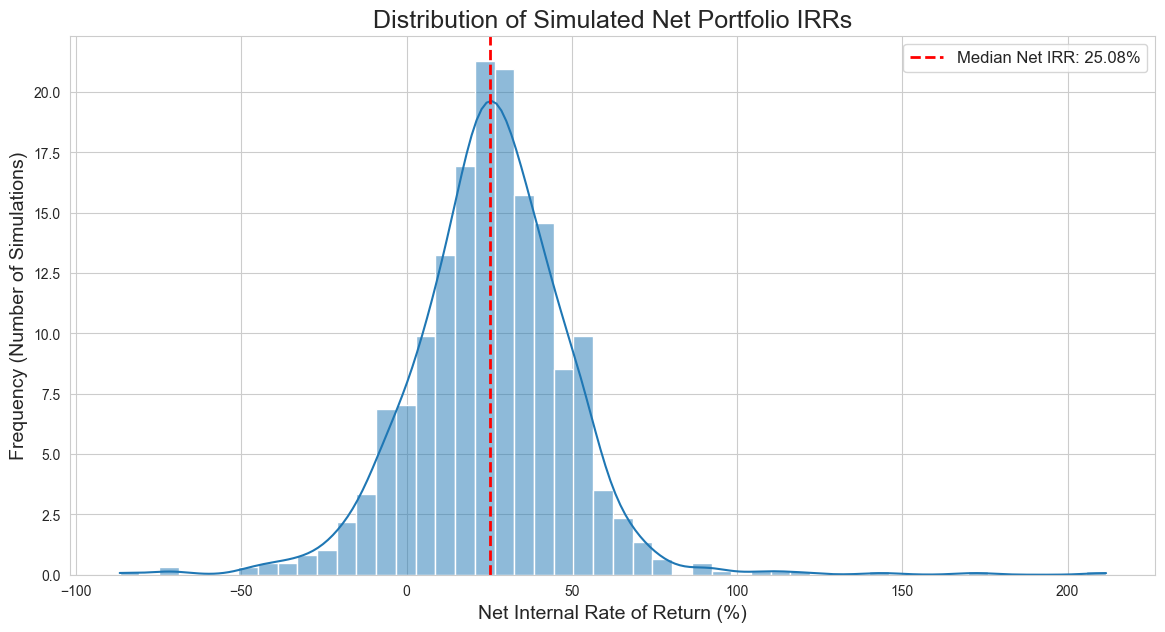

In [5]:
# ==============================================================================
# --- FINAL ANALYSIS & VISUALIZATION OF BASE CASE RESULTS ---
# ==============================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if 'all_results' in locals() and all_results:
    
    # --- 1. Data Aggregation ---
    # This correctly converts the list of PortfolioResult objects into a DataFrame,
    # which is the standard and most efficient way to handle the data.
    df_results = pd.DataFrame([vars(res) for res in all_results])
    df_results.company_results.to_csv('check.csv')

    # --- 2. Model Diagnostics ---
    # This is an excellent diagnostic check. It verifies the frequency of specific edge cases,
    # which is crucial for understanding the model's stability and behavior.
    print("\n" + "="*80)
    print("--- MODEL DIAGNOSTICS ---")
    print("="*80)
    
    constrained_runs_pct = df_results['capital_constrained'].mean() * 100
    print(f"Percentage of portfolios that became capital constrained: {constrained_runs_pct:.2f}%")

    floored_irr_count = (df_results['net_irr'] <= -0.999).sum()
    total_runs = len(df_results)
    print(f"Percentage of Net IRRs floored to -100% (total loss): {(floored_irr_count/total_runs)*100:.2f}%")

    # --- 3. Descriptive Statistics & Risk Metrics ---
    # This section provides a comprehensive statistical summary and is a cornerstone of any
    # institutional-grade Monte Carlo analysis.
    print("\n\n" + "="*80)
    print("--- PORTFOLIO PERFORMANCE STATISTICS ---")
    print("="*80)
    
    # The use of describe() with custom percentiles is best practice.
    summary_stats = df_results[['gross_irr', 'net_irr', 'gross_multiple', 'net_multiple']].describe(percentiles=[.05, .25, .5, .75, .95])
    
    # The formatting logic below is excellent for presentation-ready tables.
    styler = summary_stats.style.format({
        'gross_irr': '{:,.2%}',
        'net_irr': '{:,.2%}',
        'gross_multiple': '{:,.2f}x',
        'net_multiple': '{:,.2f}x'
    }, na_rep="-").format("{:,.0f}", subset=pd.IndexSlice['count', :])

    print("\nIRR & Multiple Statistics:")
    display(styler)

    # The inclusion of VaR and CVaR demonstrates a sophisticated understanding of risk analysis.
    # These are key metrics that institutional investors look for.
    print("\nKey Risk Metrics (Based on Net IRR):")
    var_5_net = summary_stats.loc['5%', 'net_irr']
    cvar_5_net = df_results[df_results['net_irr'] <= var_5_net]['net_irr'].mean()
    print(f"  Value at Risk (VaR) at 5%: {var_5_net:.2%} (The worst-case outcome in 95% of scenarios)")
    print(f"  Conditional VaR (CVaR) at 5%: {cvar_5_net:.2%} (The average outcome of the worst 5% of scenarios)")

    # --- 4. Visualization ---
    # This is a perfect visualization for summarizing the results of a Monte Carlo simulation.
    print("\n\n" + "="*80)
    print("--- VISUALIZATION: NET IRR DISTRIBUTION ---")
    print("="*80)
    
    plt.figure(figsize=(14, 7))
    # Filtering out the extreme -100% IRR values is a smart choice for better visualization.
    viz_data = df_results[df_results['net_irr'] > -0.99]['net_irr'] * 100
    sns.histplot(viz_data, kde=True, stat='frequency', bins=50)
    
    plt.title('Distribution of Simulated Net Portfolio IRRs', fontsize=18)
    plt.xlabel('Net Internal Rate of Return (%)', fontsize=14)
    plt.ylabel('Frequency (Number of Simulations)', fontsize=14)
    
    median_net_irr = df_results['net_irr'].median() * 100
    plt.axvline(median_net_irr, color='red', linestyle='dashed', linewidth=2, label=f'Median Net IRR: {median_net_irr:.2f}%')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

else:
    print("The 'all_results' list not found or is empty. Please run the Base Case Simulation cell first.")

In [ ]:
from typing import Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import math as math



# Import our new, separated modules
from parameters import PortfolioResult, CompanyResult,FundParameters
import engine as vcm

# This line correctly imports the fully-processed and validated
# parameters from your loader script.
from parameters_loader import fund_params as base_case_params

from analysis_utils import display_portfolio_deep_dive, display_company_journeys

def calculate_expected_investment_per_company_monte_carlo(
    params: FundParameters, 
    rng: np.random.Generator = None, 
    n_simulations: int = 10000,
    verbose: bool = False
) -> Dict:
    """
    Calculates the expected total investment per company across all stages using Monte Carlo simulation,
    considering survival probabilities, follow-on requirements, and different investment strategies.
    
    Args:
        params: Fund parameters containing stage definitions and strategy
        rng: Random number generator for reproducible results
        n_simulations: Number of Monte Carlo simulations to run
        verbose: Whether to print debug information
        
    Returns:
        Dictionary with investment expectations by initial stage
    """
    if rng is None:
        rng = np.random.default_rng(seed=42) 

    results = {}
    stages = params.stages_order
    
    # Loop through each possible initial stage (excluding last 2 stages)
    for calculation_stage in range(0, len(stages) - 2):
        
        initial_stage_idx = calculation_stage
        current_stage = stages[initial_stage_idx]
        initial_stage = current_stage
        
        if verbose:
            print(f"\n=== Analyzing initial stage: {initial_stage} ===")
        
        # Sample initial valuations from lognormal distribution
        mu_log = params.stages[current_stage].post_money_valuation_dist.mu_log
        sigma_log = params.stages[current_stage].post_money_valuation_dist.sigma_log
        
        if verbose:
            print(f'Mu_log: {mu_log}, Sigma_log: {sigma_log}')
        
        valuation_sample = rng.lognormal(mean=mu_log, sigma=sigma_log, size=n_simulations)
        
        if verbose:
            print(f'Initial valuation - Mean: ${np.mean(valuation_sample):,.0f}, Median: ${np.median(valuation_sample):,.0f}')
        
        # Calculate initial investment
        initial_ownership = params.initial_ownership_targets[current_stage]
        initial_investment = valuation_sample * initial_ownership
        
        if verbose:
            print(f'Initial investment - Mean: ${np.mean(initial_investment):,.0f}')
        
        # Initialize tracking variables
        survival_rate = 1.0
        cumulative_investment = initial_investment.copy()
        
        # Determine follow-on strategy
        strategy_type = params.follow_on_strategy.type
        
        if strategy_type == "spray_and_pray":
            current_pro_rata_rate = 0.0
        elif strategy_type == "passive":
            current_pro_rata_rate = params.follow_on_strategy.passive_participation_rate
        elif strategy_type == "pro_rata":
            current_pro_rata_rate = 1.0
        else:
            current_pro_rata_rate = 0.0  # Default fallback
        
        if verbose:
            print(f'Follow-on strategy: {strategy_type}, Pro-rata rate: {current_pro_rata_rate}')
            print('\n--- Follow-on rounds simulation ---')
        
        # Simulate follow-on rounds
        for stage_idx in range(initial_stage_idx, len(stages) - 2):
            current_stage = stages[stage_idx]
            
            if verbose:
                print(f'\nStage {stage_idx}: {current_stage}')
            
            # Store old valuation for multiple calculation
            old_valuation = valuation_sample.copy()
            
            # Simulate next stage valuation
            valuation_sample = quick_simulate_vectorized(
                current_stage, 
                valuation_sample, 
                n_simulations=1
            )
            
            # Calculate valuation multiple
            valuation_multiple = valuation_sample / old_valuation
            
            if verbose:
                print(f'Valuation multiple - Mean: {np.mean(valuation_multiple):.2f}x, Median: {np.median(valuation_multiple):.2f}x')
                print(f'New valuation - Mean: ${np.mean(valuation_sample):,.0f}, Median: ${np.median(valuation_sample):,.0f}')
            
            # Update survival rate
            survival_rate = survival_rate * params.stages[current_stage].prob_to_next_stage
            
            if verbose:
                print(f'Cumulative survival rate: {survival_rate:.3f}')
            
            # Calculate follow-on investment
            target_dilution = params.stages[current_stage].target_dilution_pct
            
            follow_on = (valuation_sample * target_dilution * 
                        initial_ownership * current_pro_rata_rate * survival_rate)
            
            if verbose:
                print(f'Follow-on investment - Mean: ${np.mean(follow_on):,.0f}, Median: ${np.median(follow_on):,.0f}')
            
            # Add to cumulative investment
            cumulative_investment = follow_on + cumulative_investment
            
            if verbose:
                print(f'Cumulative investment - Mean: ${np.mean(cumulative_investment):,.0f}, Median: ${np.median(cumulative_investment):,.0f}')
        
        # Store results for this initial stage
        mean_initial = np.mean(initial_investment)
        mean_cumulative = np.mean(cumulative_investment)
        
        results[initial_stage] = {
            'initial_investment': mean_initial,
            'total_expected_investment': mean_cumulative,
            'follow_on_multiple': mean_cumulative / mean_initial if mean_initial > 0 else 0,
            'simulation_stats': {
                'initial_investment_median': np.median(initial_investment),
                'total_expected_investment_median': np.median(cumulative_investment),
                'initial_investment_std': np.std(initial_investment),
                'total_expected_investment_std': np.std(cumulative_investment)
            }
        }
        
        if verbose:
            print(f'\n=== Final Results for {initial_stage} ===')
            print(f'Mean Initial Investment: ${mean_initial:,.0f}')
            print(f'Mean Total Expected Investment: ${mean_cumulative:,.0f}')
            print(f'Follow-on Multiple: {mean_cumulative / mean_initial:.2f}x')
    
    return results


def calculate_optimal_portfolio_size(
    params: FundParameters,
    rng: np.random.Generator = None,
    n_simulations: int = 10000
) -> Dict:
    """
    Calculates the optimal number of initial investments using year-by-year, deal-by-deal simulation
    until capital constraints are reached.
    
    Args:
        params: Fund parameters containing allocation strategy and constraints
        rng: Random number generator for stage selection (optional, will create if None)
        n_simulations: Number of Monte Carlo simulations for expected investment calculation
        
    Returns:
        Dictionary with optimal portfolio sizing analysis
    """
    
    if rng is None:
        rng = np.random.default_rng(seed=42)
    
    # Calculate expected investments per company using Monte Carlo
    expected_investments = calculate_expected_investment_per_company_monte_carlo(
        params, n_simulations=n_simulations, verbose=False
    )
    
    # Available capital for investments
    available_capital = params.committed_capital * params.target_investable_capital_pct
    
    # Initialize tracking variables
    cumulative_expected_investment = 0.0
    total_deals = 0
    deals_by_year = {}
    deals_by_stage = {}
    investment_timeline = []
    
    # Get list of available stages from expected_investments
    available_stages = list(expected_investments.keys())
    
    # Loop through years and deals
    for stage_allocation_obj in params.dynamic_stage_allocation:
        year = stage_allocation_obj.year
        deals_by_year[year] = 0
        
        # Extract stage probabilities for this year
        stage_probs = []
        stage_names = []
        
        for stage in available_stages:
            if stage in stage_allocation_obj.allocation:
                stage_names.append(stage)
                stage_probs.append(stage_allocation_obj.allocation[stage])
        
        # Normalize probabilities (in case they don't sum to 1)
        if sum(stage_probs) > 0:
            stage_probs = np.array(stage_probs) / sum(stage_probs)
        else:
            continue  # Skip year if no valid allocations
        
        # Loop through deals for this year
        for deal_in_year in range(params.max_deals_per_year):
            # Select stage based on allocation probabilities
            selected_stage = rng.choice(stage_names, p=stage_probs)
            
            # Get expected investment for this stage
            deal_expected_investment = expected_investments[selected_stage]['total_expected_investment']
            
            # Check if this deal would exceed available capital
            if cumulative_expected_investment + deal_expected_investment > available_capital:
                # We've hit the capital constraint
                break
            
            # Add this deal
            cumulative_expected_investment += deal_expected_investment
            total_deals += 1
            deals_by_year[year] += 1
            
            # Track deals by stage
            if selected_stage not in deals_by_stage:
                deals_by_stage[selected_stage] = 0
            deals_by_stage[selected_stage] += 1
            
            # Track investment timeline
            investment_timeline.append({
                'deal_number': total_deals,
                'year': year,
                'stage': selected_stage,
                'deal_investment': deal_expected_investment,
                'cumulative_investment': cumulative_expected_investment
            })
        
        # If we hit capital constraint, break out of year loop too
        if cumulative_expected_investment + min([expected_investments[s]['total_expected_investment'] 
                                               for s in available_stages]) > available_capital:
            break
    
    # Calculate statistics
    avg_expected_investment = cumulative_expected_investment / total_deals if total_deals > 0 else 0
    capital_utilization = cumulative_expected_investment / available_capital if available_capital > 0 else 0
    
    # Add safety margin (e.g., 10% buffer)
    conservative_num_investments = int(total_deals * 0.9)
    
    return {
        'current_num_investments': params.num_investments,
        'available_capital': available_capital,
        'optimal_num_investments': total_deals,
        'conservative_num_investments': conservative_num_investments,
        'total_expected_investment': cumulative_expected_investment,
        'avg_expected_investment_per_company': avg_expected_investment,
        'expected_capital_utilization': capital_utilization,
        'remaining_capital': available_capital - cumulative_expected_investment,
        'deals_by_year': deals_by_year,
        'deals_by_stage': deals_by_stage,
        'investment_timeline': investment_timeline,
        'stage_breakdown': expected_investments
    }


def analyze_capital_allocation(params: FundParameters, rng: np.random.Generator = None):
    """
    Provides a comprehensive analysis of capital allocation optimization using Monte Carlo simulation.
    """
    
    if rng is None:
        rng = np.random.default_rng(seed=42)
    
    # First calculate expected investments per company using Monte Carlo
    expected_investments = calculate_expected_investment_per_company_monte_carlo(
        params, rng, n_simulations=10000, verbose=False
    )
    
    # Then calculate optimal portfolio size using deal-by-deal simulation
    analysis = calculate_optimal_portfolio_size(params, expected_investments, rng)
    
    print("=== CAPITAL ALLOCATION ANALYSIS ===\n")
    print(f"Fund Size: ${params.committed_capital:,.0f}")
    print(f"Available for Investments: ${analysis['available_capital']:,.0f}")
    print(f"Target Investment %: {params.target_investable_capital_pct:.1%}")
    print(f"Max Deals per Year: {params.max_deals_per_year}\n")
    
    print("=== PORTFOLIO SIZING ===")
    print(f"Current Portfolio Size: {analysis['current_num_investments']} companies")
    print(f"Optimal Portfolio Size: {analysis['optimal_num_investments']} companies")
    print(f"Conservative Portfolio Size: {analysis['conservative_num_investments']} companies")
    print(f"Expected Capital Utilization: {analysis['expected_capital_utilization']:.1%}")
    print(f"Remaining Capital: ${analysis['remaining_capital']:,.0f}\n")
    
    print(f"Average Expected Investment per Company: ${analysis['avg_expected_investment_per_company']:,.0f}")
    print(f"Total Expected Investment: ${analysis['total_expected_investment']:,.0f}\n")
    
    print("=== DEALS BY YEAR ===")
    for year, deals in analysis['deals_by_year'].items():
        if deals > 0:
            print(f"Year {year}: {deals} deals")
    
    print("\n=== DEALS BY STAGE ===")
    for stage, deals in analysis['deals_by_stage'].items():
        print(f"{stage}: {deals} deals ({deals/analysis['optimal_num_investments']:.1%})")
    
    print("\n=== BY STAGE BREAKDOWN ===")
    for stage, data in analysis['stage_breakdown'].items():
        print(f"{stage}:")
        print(f"  Initial Investment: ${data['initial_investment']:,.0f}")
        print(f"  Total Expected: ${data['total_expected_investment']:,.0f}")
        print(f"  Follow-on Multiple: {data['follow_on_multiple']:.2f}x")
    
    return analysis


def quick_simulate_vectorized(stage: str, from_valuations, n_simulations: int = 1):
    """
    Vectorized simulation for multiple initial valuations.
    
    Parameters:
    stage: Stage name
    from_valuations: Single valuation (float) or array of valuations
    n_simulations: Number of simulations per valuation
    
    Returns:
    - If n_simulations=1: 1D array of next valuations (same length as input)
    - If n_simulations>1: 2D array of shape (len(from_valuations), n_simulations)
    - If single valuation input: behaves like quick_simulate()
    """
    rng = np.random.default_rng(seed=42)
    model_params = {
        'Pre-Seed': {'alpha': 7.9438, 'beta': 0.4823, 'residual_std': 1.0643},
        'Seed': {'alpha': 9.7765, 'beta': 0.5139, 'residual_std': 0.7872},
        'Series A': {'alpha': 7.4050, 'beta': 0.3594, 'residual_std': 0.7012},
        'Series B': {'alpha': 6.7335, 'beta': 0.3115, 'residual_std': 0.8112}
    }
    
    if stage not in model_params:
        raise ValueError(f"Stage '{stage}' not supported. Available: {list(model_params.keys())}")
    
    params = model_params[stage]
    
    # Convert input to numpy array for consistent handling
    from_valuations = np.atleast_1d(from_valuations)
    is_single_input = len(from_valuations) == 1
    
    # Calculate expected log(multiples) for each valuation
    expected_log_multiples = params['alpha'] - params['beta'] * np.log(from_valuations)
    
    # Generate random noise
    if n_simulations == 1:
        # Single simulation per valuation - return 1D array
        noise = rng.normal(0, params['residual_std'], size=len(from_valuations))
        log_multiples = expected_log_multiples + noise
        multiples = np.exp(log_multiples)
        next_valuations = from_valuations * multiples
        
        # Return scalar if single input, otherwise return 1D array
        return float(next_valuations[0]) if is_single_input else next_valuations
        
    else:
        # Multiple simulations - return 2D array
        noise = rng.normal(0, params['residual_std'], 
                               size=(len(from_valuations), n_simulations))
        log_multiples = expected_log_multiples.reshape(-1, 1) + noise
        multiples = np.exp(log_multiples)
        next_valuations = from_valuations.reshape(-1, 1) * multiples
        
        # Return 1D array if single input, otherwise return 2D array
        return next_valuations[0] if is_single_input else next_valuations

In [5]:
# ==============================================================================
# --- DEBUGGER: Deep Dive into a Single Portfolio's Lifecycle ---
# ==============================================================================
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

# --- Configuration ---
SEED_TO_ANALYZE = 42
FUND_START_DATE = datetime.strptime(base_case_params.scenario.date, '%Y-%m-%d')

# --- 1. Run a single, deterministic simulation ---
print(f"--- Running Deep Dive Analysis for Portfolio (seed={SEED_TO_ANALYZE}) ---")
rng_for_debug = np.random.default_rng(seed=SEED_TO_ANALYZE)
single_run_result, debug_cash_flows, _ = vcm.debug_one_simulation(
    params=base_case_params,
    rng=rng_for_debug
)

if not single_run_result:
    print("❌ Simulation failed to produce a result for this seed.")
else:
    # --- Create a master DataFrame of all raw cash flows for analysis ---
    df_debug_flows = pd.DataFrame(debug_cash_flows, columns=['amount', 'time_months', 'id'])
    
    # ==============================================================================
    # --- A. Initial Investment Debugger ---
    # ==============================================================================
    print("\n" + "="*80)
    print("--- 🕵️ Initial Investment Calculation Debugger ---")
    print("="*80)

    if not single_run_result.company_results:
        print("No companies were created in this simulation run.")
    else:
        first_company_result = single_run_result.company_results[0]
        cid_to_debug = first_company_result.company_id
        investment_event = next((cf for cf in debug_cash_flows if cf[2] == cid_to_debug and cf[0] < 0), None)
        initial_history = first_company_result.history[0] if first_company_result.history else None

        if investment_event and initial_history:
            initial_investment_amount = abs(investment_event[0])
            post_money_valuation = initial_history['valuation']
            company_stage = initial_history['stage']
            target_ownership = base_case_params.initial_ownership_targets.get(company_stage, 'N/A')
            calculated_ownership = initial_investment_amount / post_money_valuation if post_money_valuation > 0 else 0

            print(f"Debugging Initial Investment for Company ID: {cid_to_debug} (Stage: {company_stage})")
            print(f"  - Target Ownership (from config):  {target_ownership:.2%}")
            print("--------------------------------------------------")
            print(f"  - Post-Money Valuation (sampled):  ${post_money_valuation:,.0f}")
            print(f"  - Initial Investment Amount:       ${initial_investment_amount:,.0f}")
            print("--------------------------------------------------")
            print(f"  - Resulting Ownership:             {calculated_ownership:.2%}")
        else:
            print("Could not find the initial investment event for debugging.")

    # ==============================================================================
    # --- B. Fund Capital Deployment Summary (Corrected) ---
    # ==============================================================================
    print("\n\n" + "="*80)
    print("--- 1. Fund Capital Deployment Summary ---")
    print("="*80)

    df_companies = pd.DataFrame([vars(res) for res in single_run_result.company_results])
    
    total_capital_called = abs(df_debug_flows[df_debug_flows['id'] == -2]['amount'].sum())
    total_investments = df_companies['total_invested'].sum() if not df_companies.empty else 0
    total_mgmt_fees = abs(df_debug_flows[df_debug_flows['id'] == -1]['amount'].sum())
    uncalled_capital = base_case_params.committed_capital - total_capital_called

    print(f"Committed Capital:         ${base_case_params.committed_capital:,.0f}")
    print(f"Capital Constrained:       {single_run_result.capital_constrained}")
    print("------------------------------------------------------------")
    print(f"Total Investments Made:      ${total_investments:,.0f}")
    print(f"Total Management Fees Paid:  ${total_mgmt_fees:,.0f}")
    print("------------------------------------------------------------")
    print(f"Total Capital Called:        ${total_capital_called:,.0f}")
    print(f"Uncalled Capital:            ${uncalled_capital:,.0f}")
    print("="*80)


    # ==============================================================================
    # --- C. Detailed Company Journeys (Valuation & Ownership) ---
    # ==============================================================================
    print("\n\n" + "="*80)
    print("--- 2. Detailed Company Journeys (Valuation & Ownership) ---")
    print("="*80)

    journey_data = []
    for company_res in single_run_result.company_results:
        for event in company_res.history:
            ownership_pct = company_res.total_invested / event['valuation'] if event['valuation'] > 0 else 0
            journey_data.append({
                'Company ID': company_res.company_id, 'Time (Months)': event['time'], 'Event': event['event'],
                'Stage': event['stage'], 'Valuation': event['valuation'], 'Fund Ownership': ownership_pct, 'Proceeds': 0
            })
        journey_data.append({
            'Company ID': company_res.company_id,
            'Time (Months)': company_res.time_to_exit_months + company_res.history[0]['time'] if company_res.time_to_exit_months is not None else np.nan,
            'Event': f"FINAL: {company_res.outcome}", 'Stage': company_res.history[-1]['stage'] if company_res.history else 'N/A',
            'Valuation': np.nan, 'Fund Ownership': np.nan, 'Proceeds': company_res.exit_proceeds
        })

    df_journey = pd.DataFrame(journey_data)
    df_journey_sorted = df_journey.sort_values(by=['Company ID', 'Time (Months)']).reset_index(drop=True)

    display(df_journey_sorted.style.format({
        'Time (Months)': "{:.1f}", 'Valuation': "${:,.0f}",
        'Fund Ownership': "{:.2%}", 'Proceeds': "${:,.0f}"
    }).hide(axis="index").set_caption("Company-by-company evolution from investment to final outcome."))


    # ==============================================================================
    # --- D. Waterfall Validation ---
    # ==============================================================================
    print("\n\n" + "="*80)
    print("--- 3. Waterfall Calculation Validation ---")
    print("="*80)
    
    _, _, df_waterfall_details = vcm.apply_fund_structure(debug_cash_flows, base_case_params, single_run_result.final_fund_life_years * 12)

    if not df_waterfall_details.empty:
        currency_format = "${:,.0f}"
        display(df_waterfall_details.style.format({col: currency_format for col in df_waterfall_details.columns if 'Year' not in col}).set_caption("Annual breakdown of the fund's distribution waterfall."))
    else:
        print("No distributable cash was generated in this simulation run.")

--- Running Deep Dive Analysis for Portfolio (seed=42) ---

STEP 1: Processing CONSIDER_NEW_INVESTMENT at 2.63 months (0.2 years)

--- PROCESSING NEW INVESTMENT CONSIDERATION ---
deals_per_year: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Investment period: True
Deal capacity: True (deals this year: 0/6)
Portfolio capacity: True (investments: 0/20)

--- GENERATING DEAL ---
Chosen stage: Seed
Post-money valuation: $19,500,000
Ownership target: 15.0%
Investment amount: $2,925,000
Investable capital remaining: $40,000,000
INVESTMENT EXECUTED!
Company 1 created in Seed stage
Milestone scheduled at 20.63 months
Next investment consideration scheduled at 3.82 months

STEP 2: Processing CONSIDER_NEW_INVESTMENT at 3.82 months (0.3 years)

--- PROCESSING NEW INVESTMENT CONSIDERATION ---
deals_per_year: {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Investment period: True
Deal capacity: True (deals this year: 1/6)
Portfolio capacity: True (investments: 1/20)

--- GENERATING DEAL ---
Chosen stage: Seed
Post-mone

Company ID,Time (Months),Event,Stage,Valuation,Fund Ownership,Proceeds
1,2.6,Initial Investment,Seed,"$19,500,000",30.68%,$0
1,20.6,Follow-on,Series A,"$24,800,000",24.12%,$0
1,44.6,Follow-on,Series B,"$102,800,000",5.82%,$0
1,74.6,Exit,Exited,"$312,900,000",1.91%,$0
1,74.6,FINAL: exited,Exited,$nan,nan%,"$46,935,000"
2,3.8,Initial Investment,Seed,"$7,700,000",42.70%,$0
2,21.8,Follow-on,Series A,"$71,100,000",4.62%,$0
2,45.8,FINAL: failed,Series A,$nan,nan%,$0
3,6.4,Initial Investment,Pre-Seed,"$1,100,000",15.00%,$0
3,18.4,FINAL: failed,Pre-Seed,$nan,nan%,$0




--- 3. Waterfall Calculation Validation ---


,Pref Balance Start,Distributable Cash,ROC to LP,ROC to GP,Pref to LP,Catch-up to GP,Final Split to GP,Total to LP,Total Carry to GP
Year,,,,,,,,,
1,$0,"$-5,490,000","$-5,435,100","$-54,900",$0,$0,$0,"$-5,435,100",$0
2,$0,"$-6,147,000","$-6,085,530","$-61,470",$0,$0,$0,"$-6,085,530",$0
3,"$1,424,808","$-8,040,000","$-7,959,600","$-80,400",$0,$0,$0,"$-7,959,600",$0
4,"$4,326,458","$-11,550,000","$-11,434,500","$-115,500",$0,$0,$0,"$-11,434,500",$0
5,"$7,864,877","$5,361,000","$5,307,390","$53,610",$0,$0,$0,"$5,307,390",$0
6,"$13,308,055","$-2,691,000","$-2,664,090","$-26,910",$0,$0,$0,"$-2,664,090",$0
7,"$19,316,642","$46,935,000","$46,465,650","$469,350",$0,$0,$0,"$46,465,650",$0
8,"$25,538,357",$0,$0,$0,$0,$0,$0,$0,$0
9,"$28,042,819","$58,127,250","$31,305,780","$316,220","$26,505,250",$0,$0,"$57,811,030",$0


--- Running Diagnostic Analysis on Gross Investment Performance ---

--- Investigation 1: Why Are Companies Failing? ---


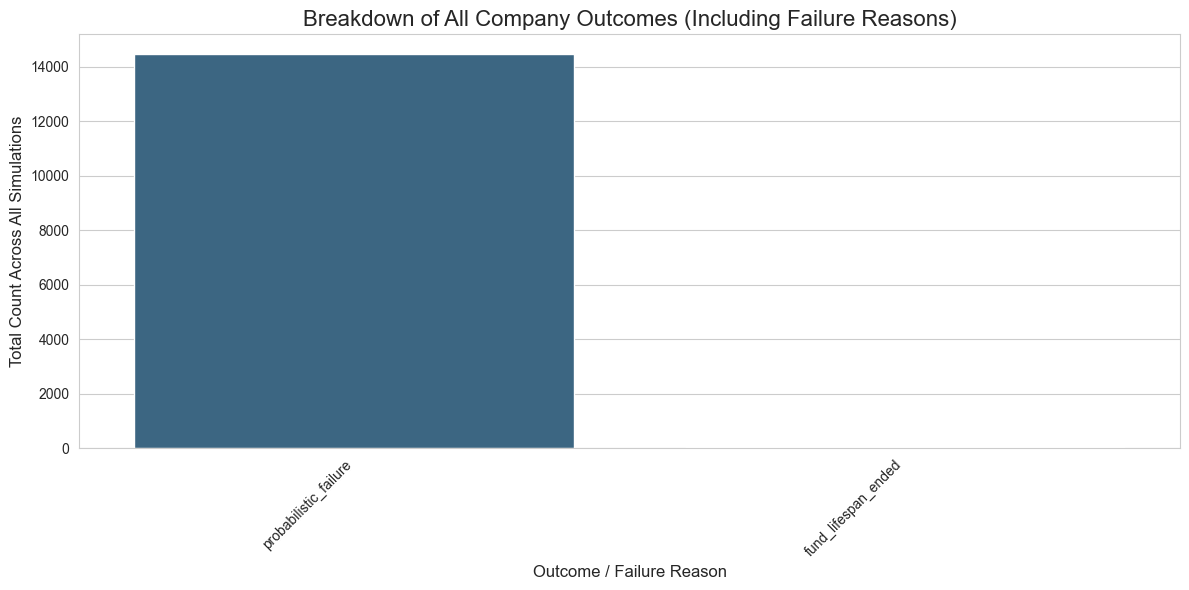


--- Investigation 2: Are Our Winners Big Enough? ---
No successful exits were recorded in any simulation run.


In [6]:
# ==============================================================================
# --- AGGREGATE ANALYSIS: Diagnosing Gross Performance ---
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Running Diagnostic Analysis on Gross Investment Performance ---")

# --- 1. Extract All Company-Level Results into a Single DataFrame ---
if 'all_results' in locals() and all_results:
    all_company_results_df = pd.DataFrame(
        [vars(company) for portfolio in all_results for company in portfolio.company_results]
    )
else:
    all_company_results_df = pd.DataFrame()

if all_company_results_df.empty:
    print("❌ No company results were generated in the simulation.")
else:
    # --- 2. Analyze Failure Rates & Reasons ---
    print("\n" + "="*80)
    print("--- Investigation 1: Why Are Companies Failing? ---")
    print("="*80)
    
    failure_reason_counts = all_company_results_df['failure_reason'].value_counts(dropna=False).fillna('Success/Exit')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=failure_reason_counts.index, y=failure_reason_counts.values, palette="viridis")
    plt.title('Breakdown of All Company Outcomes (Including Failure Reasons)', fontsize=16)
    plt.ylabel('Total Count Across All Simulations', fontsize=12)
    plt.xlabel('Outcome / Failure Reason', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- 3. Analyze Performance of Successful Exits ---
    print("\n" + "="*80)
    print("--- Investigation 2: Are Our Winners Big Enough? ---")
    print("="*80)
    
    # Filter for only the companies that successfully exited
    successful_exits_df = all_company_results_df[all_company_results_df['outcome'] == 'exit'].copy()

    if successful_exits_df.empty:
        print("No successful exits were recorded in any simulation run.")
    else:
        # Calculate key performance indicators for the winners
        median_moic = successful_exits_df['multiple'].median()
        avg_moic = successful_exits_df['multiple'].mean()
        pct_over_5x = (successful_exits_df['multiple'] > 5).mean() * 100
        pct_over_10x = (successful_exits_df['multiple'] > 10).mean() * 100

        print(f"Median MOIC on Successful Exits: {median_moic:.2f}x")
        print(f"Average MOIC on Successful Exits: {avg_moic:.2f}x")
        print(f"Percentage of Exits > 5x: {pct_over_5x:.2f}%")
        print(f"Percentage of Exits > 10x (Home Runs): {pct_over_10x:.2f}%\n")

        # Visualize the distribution of exit multiples
        plt.figure(figsize=(12, 6))
        # We clip the x-axis to make the visualization readable, as a few outliers can stretch the plot
        sns.histplot(successful_exits_df['multiple'].clip(upper=50), bins=50, kde=False)
        plt.title('Distribution of MOIC for Successful Exits', fontsize=16)
        plt.xlabel('Multiple on Invested Capital (MOIC) - Capped at 50x for visualization', fontsize=12)
        plt.ylabel('Number of Companies', fontsize=12)
        plt.axvline(median_moic, color='red', linestyle='--', label=f'Median MOIC: {median_moic:.2f}x')
        plt.legend()
        plt.grid(True)
        plt.show()

In [7]:
# Debugging Cell

import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Import your project's modules
import engine as vcm
from parameters_loader import fund_params
from waterfall import apply_fund_structure
from utils import xirr

# --- Configuration ---
SEED_TO_ANALYZE = 42
START_DATE = datetime(2025, 7, 2) # A fixed start date for consistency

# --- Simulation & Calculation ---

print(f"--- Running In-Notebook Analysis for Portfolio (seed={SEED_TO_ANALYZE}) ---")

# 1. Run a single, deterministic simulation
rng = np.random.default_rng(seed=SEED_TO_ANALYZE)
result, gross_cash_flows, _ = vcm.debug_one_simulation(
    params=fund_params,
    rng=rng
)

if not result or not gross_cash_flows:
    print("\n❌ Simulation failed to produce results for this seed.")
else:
    # 2. Process Gross Flows to add descriptions
    detailed_gross_flows = []
    invested_company_ids = set()
    sorted_gross_flows = sorted(gross_cash_flows, key=lambda x: x[1])

    for amount, time_months, cid in sorted_gross_flows:
        flow_type = "Unknown"
        if cid == -1:
            flow_type = "Management Fee"
        elif cid > 0:
            if amount < 0:
                if cid not in invested_company_ids:
                    flow_type = "First Ticket Investment"
                    invested_company_ids.add(cid)
                else:
                    flow_type = "Follow On Investment"
            else:
                flow_type = "Exit Proceeds"

        if cid != -2: # Exclude internal capital calls from the Gross view
             detailed_gross_flows.append((time_months, amount, flow_type))

    # 3. Create a DataFrame for Gross Cash Flows
    gross_df = pd.DataFrame(detailed_gross_flows, columns=['Months', 'Amount', 'Type'])

    # 4. Create a DataFrame for Net LP Cash Flows
    net_lp_flows, _, _ = apply_fund_structure(
        gross_fund_flows_tagged=gross_cash_flows,
        params=fund_params,
        actual_fund_lifespan_months=result.final_fund_life_years * 12
    )
    
    detailed_net_flows = []
    for amount, time_years in net_lp_flows:
        flow_type = "LP Distribution" if amount > 0 else "LP Contribution"
        detailed_net_flows.append((time_years * 12, amount, flow_type))
    
    net_df = pd.DataFrame(detailed_net_flows, columns=['Months', 'Amount', 'Type'])

    # 5. Calculate IRRs using the raw, unformatted data
    gross_irr_flows = list(gross_df[['Amount', 'Months']].itertuples(index=False, name=None))
    gross_irr = xirr(gross_irr_flows, time_unit='months')
    
    net_irr_flows = list(net_df[['Amount', 'Months']].itertuples(index=False, name=None))
    net_irr = xirr(net_irr_flows, time_unit='months')
    
    # --- 6. Format DataFrames for Final Display ---

    # Date formatting function
    def format_date(months):
        date = START_DATE + timedelta(days=months * 30.4375)
        return date.strftime('%d-%m-%Y')

    # Apply formatting
    gross_df['Date'] = gross_df['Months'].apply(format_date)
    net_df['Date'] = net_df['Months'].apply(format_date)
    
    # Define display formatters
    format_dict = {
        'Amount': '{:,.0f}'.format, # Comma separator, no decimals
        'Date': '{}'.format,
        'Type': '{}'
    }

    # Reorder columns for final presentation
    gross_df_display = gross_df[['Date', 'Type', 'Amount']]
    net_df_display = net_df[['Date', 'Type', 'Amount']]

    print("\n--- 📈 Gross Cash Flows (Fund Perspective) ---")
    display(gross_df_display.style.format(format_dict).hide(axis="index"))
    
    print("\n--- 💵 Net Cash Flows (LP Perspective) ---")
    display(net_df_display.style.format(format_dict).hide(axis="index"))
    
    print("\n--- 📊 Final IRR Summary ---")
    print("==========================================")
    if gross_irr is not None:
        print(f"📈 Gross IRR: {gross_irr:.2%}")
    else:
        print("📈 Gross IRR: Calculation Failed")

    if net_irr is not None:
        print(f"💵 Net IRR:   {net_irr:.2%}")
    else:
        print("💵 Net IRR:   Calculation Failed")
    print("==========================================")

--- Running In-Notebook Analysis for Portfolio (seed=42) ---

STEP 1: Processing CONSIDER_NEW_INVESTMENT at 2.63 months (0.2 years)

--- PROCESSING NEW INVESTMENT CONSIDERATION ---
deals_per_year: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Investment period: True
Deal capacity: True (deals this year: 0/6)
Portfolio capacity: True (investments: 0/20)

--- GENERATING DEAL ---
Chosen stage: Seed
Post-money valuation: $19,500,000
Ownership target: 15.0%
Investment amount: $2,925,000
Investable capital remaining: $40,000,000
INVESTMENT EXECUTED!
Company 1 created in Seed stage
Milestone scheduled at 20.63 months
Next investment consideration scheduled at 3.82 months

STEP 2: Processing CONSIDER_NEW_INVESTMENT at 3.82 months (0.3 years)

--- PROCESSING NEW INVESTMENT CONSIDERATION ---
deals_per_year: {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Investment period: True
Deal capacity: True (deals this year: 1/6)
Portfolio capacity: True (investments: 1/20)

--- GENERATING DEAL ---
Chosen stage: Seed
Post-mo

Date,Type,Amount
20-09-2025,First Ticket Investment,"-2,925,000"
26-10-2025,First Ticket Investment,"-1,155,000"
12-01-2026,First Ticket Investment,"-165,000"
06-03-2026,First Ticket Investment,"-1,080,000"
26-05-2026,First Ticket Investment,"-165,000"
02-07-2026,Management Fee,"-1,000,000"
29-07-2026,First Ticket Investment,"-1,185,000"
06-10-2026,First Ticket Investment,"-450,000"
03-01-2027,First Ticket Investment,"-615,000"
15-02-2027,First Ticket Investment,"-690,000"



--- 💵 Net Cash Flows (LP Perspective) ---


Date,Type,Amount
02-07-2026,LP Contribution,"-17,810,100"
02-07-2027,LP Contribution,"-17,085,420"
01-07-2028,LP Contribution,"-8,161,560"
02-07-2029,LP Contribution,"-21,751,290"
02-07-2030,LP Contribution,"-2,309,670"
02-07-2031,LP Contribution,"-2,733,142"
01-07-2032,LP Distribution,"1,866,645"
02-07-2034,LP Distribution,"289,857,138"
02-07-2035,LP Distribution,"501,676,807"



--- 📊 Final IRR Summary ---
📈 Gross IRR: 58.99%
💵 Net IRR:   40.41%


In [8]:
# debugging cell

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import engine as vcm
from parameters_loader import fund_params as base_case_params
from waterfall import apply_fund_structure

def export_detailed_simulation_for_excel(params, seed):
    """
    Runs a single simulation and exports its Gross and Net cash flows
    into separate, Excel-ready CSV files with a new 'Type' column
    for detailed transaction descriptions.
    """
    print(f"--- Running Simulation (seed={seed}) for Detailed Excel Export ---")

    # 1. Run the simulation to get the raw cash flow data
    rng = np.random.default_rng(seed=seed)
    result, gross_cash_flows, _ = vcm.debug_one_simulation(
        params=params,
        rng=rng
    )

    if not result or not gross_cash_flows:
        print("\n❌ Simulation failed to produce results for this seed.")
        return

    # --- 2. Process Gross Flows to Add Descriptions ---
    
    detailed_gross_flows = []
    invested_company_ids = set() # To track first vs. follow-on investments

    # Sort by time to process chronologically
    sorted_gross_flows = sorted(gross_cash_flows, key=lambda x: x[1])

    for amount, time_months, cid in sorted_gross_flows:
        flow_type = "Unknown"
        if cid == -1:
            flow_type = "Management Fee"
        elif cid == -2:
            flow_type = "Capital Call (LP Contribution)"
        elif cid > 0:
            if amount < 0:
                if cid not in invested_company_ids:
                    flow_type = "First Ticket Investment"
                    invested_company_ids.add(cid)
                else:
                    flow_type = "Follow On Investment"
            else: # amount > 0
                flow_type = "Exit Proceeds"
        
        detailed_gross_flows.append((amount, time_months, flow_type))

    # --- 3. Prepare and Export GROSS Cash Flows with Details ---
    
    # Filter out internal LP-to-Fund capital calls for Gross IRR view
    gross_flows_for_export = [
        (amt, time, f_type) for amt, time, f_type in detailed_gross_flows 
        if f_type != "Capital Call (LP Contribution)"
    ]
    
    start_date = datetime.now()
    gross_df = pd.DataFrame(gross_flows_for_export, columns=['Amount', 'Time_Months', 'Type'])
    gross_df['Date'] = gross_df['Time_Months'].apply(lambda m: start_date + timedelta(days=m * 30.4375))
    gross_df = gross_df[['Date', 'Amount', 'Type']]

    gross_filename = 'gross_flows_with_desc_for_excel.csv'
    gross_df.to_csv(gross_filename, index=False, date_format='%Y-%m-%d')
    print(f"\n✅ Successfully generated Gross IRR file with details: {gross_filename}")


    # --- 4. Prepare and Export NET LP Cash Flows with Details ---

    net_lp_flows, _, _ = apply_fund_structure(
        gross_fund_flows_tagged=gross_cash_flows,
        params=params,
        actual_fund_lifespan_months=result.final_fund_life_years * 12
    )
    
    # The waterfall output is simplified, so we add simple descriptions
    detailed_net_flows = []
    for amount, time_years in net_lp_flows:
        flow_type = "LP Distribution" if amount > 0 else "LP Contribution (Capital Call)"
        detailed_net_flows.append((amount, time_years, flow_type))

    net_df = pd.DataFrame(detailed_net_flows, columns=['Amount', 'Time_Years', 'Type'])
    net_df['Date'] = net_df['Time_Years'].apply(lambda y: start_date + timedelta(days=y * 365.25))
    net_df = net_df[['Date', 'Amount', 'Type']]
    
    net_filename = 'net_lp_flows_with_desc_for_excel.csv'
    net_df.to_csv(net_filename, index=False, date_format='%Y-%m-%d')
    print(f"✅ Successfully generated Net IRR file with details:   {net_filename}")


if __name__ == "__main__":
    export_detailed_simulation_for_excel(params=base_case_params, seed=42)

2025-09-01 20:47:16,500 - WARNING - Time 96.00: Insufficient cash for fees. Fund impaired. Fee of $198,647 was NOT paid.


--- Running Simulation (seed=42) for Detailed Excel Export ---

STEP 1: Processing CONSIDER_NEW_INVESTMENT at 2.63 months (0.2 years)

--- PROCESSING NEW INVESTMENT CONSIDERATION ---
deals_per_year: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Investment period: True
Deal capacity: True (deals this year: 0/6)
Portfolio capacity: True (investments: 0/20)

--- GENERATING DEAL ---
Chosen stage: Seed
Post-money valuation: $19,500,000
Ownership target: 15.0%
Investment amount: $2,925,000
Investable capital remaining: $40,000,000
INVESTMENT EXECUTED!
Company 1 created in Seed stage
Milestone scheduled at 20.63 months
Next investment consideration scheduled at 3.82 months

STEP 2: Processing CONSIDER_NEW_INVESTMENT at 3.82 months (0.3 years)

--- PROCESSING NEW INVESTMENT CONSIDERATION ---
deals_per_year: {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Investment period: True
Deal capacity: True (deals this year: 1/6)
Portfolio capacity: True (investments: 1/20)

--- GENERATING DEAL ---
Chosen stage: Seed
Post-

In [9]:
# Debugging cell

import numpy as np
import engine as vcm
from parameters_loader import fund_params as base_case_params
from waterfall import apply_fund_structure
from utils import xirr

def calculate_and_display_irr(params, seed):
    """
    Runs a single simulation and calculates both its Gross and Net IRR.
    """
    print(f"--- Running Validation for Portfolio (seed={seed}) ---")

    # 1. Run a single, deterministic simulation to get the detailed results
    rng = np.random.default_rng(seed=seed)
    result, gross_cash_flows, _ = vcm.debug_one_simulation(
        params=params,
        rng=rng
    )

    if not result or not gross_cash_flows:
        print("\n❌ Simulation failed to produce results for this seed.")
        return

    # 2. Calculate Gross IRR
    # We filter out internal capital calls (ID = -2) for the Gross IRR calculation.
    gross_flows_for_irr = [
        (amount, time) for amount, time, cid in gross_cash_flows if cid != -2
    ]
    gross_irr = xirr(gross_flows_for_irr, time_unit='months')

    # 3. Calculate Net IRR (LP Perspective)
    # We use the full set of gross flows and process them through the waterfall.
    net_lp_flows, _, _ = apply_fund_structure(
        gross_fund_flows_tagged=gross_cash_flows,
        params=params,
        actual_fund_lifespan_months=result.final_fund_life_years * 12
    )
    net_irr = xirr(net_lp_flows, time_unit='years') # Waterfall output is annualized

    # 4. Display Results
    print("\n✅ IRR Calculation Complete:")
    print("==========================================")
    if gross_irr is not None:
        print(f"📈 Gross IRR (Fund's Investments): {gross_irr:.2%}")
    else:
        print("📈 Gross IRR (Fund's Investments): Calculation Failed")

    if net_irr is not None:
        print(f"💵 Net IRR (LP's Take-Home):       {net_irr:.2%}")
    else:
        print("💵 Net IRR (LP's Take-Home):       Calculation Failed")
    print("==========================================")


if __name__ == "__main__":
    # Use the parameters loaded from your config and the specific seed
    calculate_and_display_irr(params=base_case_params, seed=42)

--- Running Validation for Portfolio (seed=42) ---

STEP 1: Processing CONSIDER_NEW_INVESTMENT at 2.63 months (0.2 years)

--- PROCESSING NEW INVESTMENT CONSIDERATION ---
deals_per_year: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Investment period: True
Deal capacity: True (deals this year: 0/6)
Portfolio capacity: True (investments: 0/20)

--- GENERATING DEAL ---
Chosen stage: Seed
Post-money valuation: $19,500,000
Ownership target: 15.0%
Investment amount: $2,925,000
Investable capital remaining: $40,000,000
INVESTMENT EXECUTED!
Company 1 created in Seed stage
Milestone scheduled at 20.63 months
Next investment consideration scheduled at 3.82 months

STEP 2: Processing CONSIDER_NEW_INVESTMENT at 3.82 months (0.3 years)

--- PROCESSING NEW INVESTMENT CONSIDERATION ---
deals_per_year: {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
Investment period: True
Deal capacity: True (deals this year: 1/6)
Portfolio capacity: True (investments: 1/20)

--- GENERATING DEAL ---
Chosen stage: Seed
Post-money valuat

In [ ]:
# Debugging cell

import numpy as np
import pandas as pd
import engine as vcm
from parameters_loader import fund_params

# --- 1. Run a single simulation with a fixed seed to get the detailed cash flows ---
# We use debug_one_simulation to get the granular cash flow log.
print("Running a single portfolio (seed=42) to generate its cash flow...")
rng_for_csv = np.random.default_rng(seed=42)
single_run_result, debug_cash_flows, _ = vcm.debug_one_simulation(
    params=fund_params,
    rng=rng_for_csv
)

# --- 2. Create a DataFrame from the detailed cash flow log ---
# The log contains (amount, time_months, id) for every transaction.
# ID = -1 for Management Fee
# ID = -2 for Internal Capital Call (LP Contribution to Fund)
# ID > 0 for Company-related flows (Investments or Exits)

if debug_cash_flows:
    df_all_flows = pd.DataFrame(debug_cash_flows, columns=['amount', 'time_months', 'transaction_id'])

    # --- 3. Prepare the data for IRR validation ---
    # For a standard XIRR/IRR calculation in Excel, we only need two columns:
    # the date (or time period) and the cash flow amount.
    # We will exclude the internal capital call markers (ID = -2) as they
    # represent the LP's contribution *to* the fund, not the fund's *deployment*
    # of capital, which is what determines the gross IRR. The net IRR would
    # be calculated from the waterfall output, which already nets these out.
    df_for_irr = df_all_flows[df_all_flows['transaction_id'] != -2][['time_months', 'amount']]

    # --- 4. Save the corrected and complete data to a new CSV file ---
    output_filename = 'single_portfolio_cash_flows_seed_42_CORRECTED.csv'
    df_for_irr.to_csv(output_filename, index=False)

    print(f"\n✅ Successfully generated corrected CSV file: {output_filename}")
    print("This file now accurately reflects all cash flow types for validation in Excel.")

else:
    print("\n❌ The simulation did not produce any cash flows.")

In [ ]:
# Debugging cell
import pandas as pd
import numpy as np
import engine as vcm
from parameters_loader import fund_params as base_case_params
from analysis_utils import display_portfolio_deep_dive, display_company_journeys

# --- Run a single, reproducible simulation to get the correct data ---
print("--- Analyzing a single, pre-defined portfolio (seed=42) ---")
rng_for_debug = np.random.default_rng(seed=42)
single_run_result, debug_cash_flows, _ = vcm.debug_one_simulation(
    params=base_case_params, 
    rng=rng_for_debug
)

# --- Generate the Company-by-Company breakdown from the results ---
print("\\n" + "="*80)
print("--- 1. Company-Level Breakdown ---")
print("="*80)

df_companies = pd.DataFrame([vars(res) for res in single_run_result.company_results])
display_cols = {
    'company_id': 'ID', 'start_stage': 'Entry', 'end_stage': 'Outcome',
    'initial_investment': 'First Ticket', 'follow_on_investment': 'Follow On',
    'total_invested': 'Total Invested', 'final_ownership_pct': 'Final Ownership',
    'exit_valuation': 'Exit Valuation', 'proceeds_to_fund': 'Our Proceeds',
    'multiple_on_invested': 'MOIC'
}
df_display = df_companies[list(display_cols.keys())].rename(columns=display_cols)

styled_df = df_display.style.format({
    'First Ticket': "${:,.0f}", 'Follow On': "${:,.0f}", 'Total Invested': "${:,.0f}",
    'Final Ownership': "{:.2%}", 'Exit Valuation': "${:,.0f}", 'Our Proceeds': "${:,.0f}",
    'MOIC': "{:.2f}x"
}).bar(subset=['MOIC'], color='lightgreen', vmin=0, vmax=10)
    
display(styled_df)


# --- Generate the Fund Capital Deployment Summary ---
print("\\n\\n" + "="*80)
print("--- 2. Fund Capital Deployment Summary ---")
print("="*80)

df_debug_flows = pd.DataFrame(debug_cash_flows, columns=['amount', 'time_months', 'id'])
total_investments = df_companies['total_invested'].sum()
total_mgmt_fees = abs(df_debug_flows[df_debug_flows['id'] == -1]['amount'].sum())
total_outflows = total_investments + total_mgmt_fees
capital_left_over = base_case_params.committed_capital - total_outflows

print(f"Committed Capital:         ${base_case_params.committed_capital:,.0f}")
print(f"Capital Constrained:       {single_run_result.capital_constrained}")
print("------------------------------------------------------------")
print(f"Total Investments Made:      ${total_investments:,.0f}")
print(f"Total Management Fees:       ${total_mgmt_fees:,.0f}")
print("------------------------------------------------------------")
print(f"Total Capital Called:        ${total_outflows:,.0f}")
print(f"Uncalled / Leftover Capital: ${capital_left_over:,.0f}")
print("="*80)

# --- Generate the Detailed Cash Flow Log ---
print("\\n\\n" + "="*80)
print("--- 3. Detailed Portfolio Cash Flow Log ---")
print("="*80)

flow_log = df_debug_flows.copy()
flow_log['Type'] = np.where(flow_log['id'] == -1, 'Mgmt Fee', np.where(flow_log['amount'] > 0, 'Exit Proceeds', 'Investment'))
flow_log['Amount'] = flow_log['amount']
flow_log = flow_log.sort_values(by='time_months')

display(flow_log[['time_months', 'Type', 'id', 'Amount']].style.format({
    'time_months': "{:.1f}", 'Amount': "${:,.0f}"
}).hide(axis='index'))

In [ ]:
# debugging cell
# In a new cell in your VC_Fund_Model_Runner.ipynb notebook

import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import engine as vcm # Corrected import statement

print("\n\n--- Deep Dive Analysis: Searching for a Capital Constrained Run ---")

# --- 1. Find the First Capital-Constrained Simulation Run ---
target_run_index = -1
for i, r in enumerate(all_results):
    if r.capital_constrained:
        target_run_index = i
        break

# --- 2. Run Diagnostics on the Target Run ---
if target_run_index != -1:
    print(f"Found and analyzing a capital-constrained run (Index #{target_run_index}).")
    
    # Re-run this specific simulation in debug mode to get its detailed logs
    target_run_result, target_run_cash_flows, target_run_debug_log = vcm.debug_one_simulation(
        base_case_params, 
        np.random.default_rng(seed=target_run_index)
    )

    # --- 3. Build and Display the Event Timeline from Cash Flows ---
    fund_start_date = datetime.strptime(base_case_params.scenario.date, '%Y-%m-%d')
    df_flows = pd.DataFrame(target_run_cash_flows, columns=['Amount', 'Month', 'Company_ID'])
    df_flows = df_flows[df_flows['Company_ID'] != -2] # Exclude internal capital call markers for this view

    df_flows['Outflow'] = df_flows['Amount'].apply(lambda x: abs(x) if x < 0 else 0)
    df_flows['Exit Proceeds'] = df_flows['Amount'].apply(lambda x: x if x > 0 else 0)
    
    # Use a stable sort to handle multiple events in the same month
    df_flows = df_flows.sort_values(by='Month', kind='mergesort').reset_index(drop=True)

    remaining_capital_log = []
    capital_spent_cumulative = 0
    
    for _, row in df_flows.iterrows():
        if row['Amount'] < 0:
            capital_spent_cumulative += row['Outflow']
        remaining_capital_log.append(base_case_params.committed_capital - capital_spent_cumulative)

    df_flows['Remaining_Capital'] = remaining_capital_log

    timeline_events = []
    investments_made_by_company = {}
    for index, row in df_flows.iterrows():
        event_date = fund_start_date + relativedelta(months=int(row['Month']))
        event_description = "Management Fee"
        if row['Company_ID'] > 0:
            company_id = int(row['Company_ID'])
            if row['Amount'] < 0:
                event_description = "Initial Investment" if company_id not in investments_made_by_company else "Follow-On Investment"
                investments_made_by_company[company_id] = 1
            else:
                event_description = "**Successful Exit**"

        timeline_events.append({
            'Date': event_date.strftime('%b %d, %Y'),
            'Month': row['Month'],
            'Company_ID': f"{row['Company_ID']:.0f}" if row['Company_ID'] > 0 else 'Fund',
            'Event': event_description,
            'Amount': row['Amount'],
            'Remaining_Committed_Capital': row['Remaining_Capital']
        })

    df_timeline = pd.DataFrame(timeline_events)

    print("\n--- Summary Event Timeline (What LPs See) ---")
    with pd.option_context('display.max_rows', None, 'display.width', 1000):
        display(df_timeline[['Date', 'Month', 'Company_ID', 'Event', 'Amount', 'Remaining_Committed_Capital']].style.format({
            'Amount': "${:,.0f}",
            'Remaining_Committed_Capital': "${:,.0f}",
            'Month': "{:.1f}"
        }))

    # --- 4. Build and Display the Granular Debug Log ---
    df_debug = pd.DataFrame(target_run_debug_log)
    print("\n--- Granular Fund State Log (GP's Internal View) ---")
    with pd.option_context('display.max_rows', None, 'display.width', 1000):
        # Select and format key columns for clear analysis
        display_cols = ['time', 'event', 'cash_on_hand', 'capital_called', 'msg']
        
        # Filter for columns that actually exist in the dataframe to avoid errors
        existing_cols = [col for col in display_cols if col in df_debug.columns]

        display(df_debug[existing_cols].style.format({
            'time': "{:.2f}",
            'cash_on_hand': "${:,.0f}",
            'capital_called': "${:,.0f}"
        }))

else:
    print("No capital-constrained runs were found in the simulation results.")
    print("The strategy appears robust against this particular failure mode under the current parameters.")



In [ ]:
# Monte carlo analysis
import matplotlib.pyplot as plt

# --- 1. Correctly Aggregate Company Outcomes ---
# This assumes 'all_results' is the list of PortfolioResult objects from your simulation.
all_company_outcomes = []
for result in all_results:
    for company_result in result.company_results:
        all_company_outcomes.append(company_result.end_stage)

# --- 2. Create the Value Counts ---
outcome_counts = pd.Series(all_company_outcomes).value_counts()
print("--- Aggregated Company Outcomes ---")
print(outcome_counts)

# --- 3. Plot only if data exists ---
if not outcome_counts.empty:
    print("\n--- Generating Plot ---")
    outcome_counts.plot(kind='bar', figsize=(12, 6), title='Aggregated Company Outcomes Across All Simulations')
    plt.ylabel('Total Count')
    plt.xlabel('Final Outcome')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\n--- Plotting Skipped: No company outcomes were recorded in the simulation results. ---")

In [ ]:
# Debugging cel
# --- Diagnostic Check: Investment Activity ---
# This assumes 'all_results' is the list of PortfolioResult objects from your simulation.

total_companies_finalized = sum(len(r.company_results) for r in all_results)
avg_companies = total_companies_finalized / len(all_results) if all_results else 0

print(f"Total companies finalized across all {len(all_results)} runs: {total_companies_finalized}")
print(f"Average companies per simulation run: {avg_companies:.2f}")

if avg_companies == 0:
    print("\nDIAGNOSIS: Confirmed. No investments are being finalized.")
    print("The model is running, but the strategic parameters prevent it from ever deploying capital into a company.")

In [ ]:
# Debugging


################################################################################
###
### CELL 3: MODEL SANITY CHECKS & DEEP DIVE
###
################################################################################
#
# --- Imports for this analysis cell ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# ---

print("--- Running Model Sanity Checks ---")

# ---
# Investigation 1: Capital Constraint Analysis
# ---
print("\n--- Investigation 1: Capital Constraint Analysis ---")
constrained_runs = [r for r in all_results if r.capital_constrained]

if not constrained_runs:
    print("✅ No simulations were capital constrained.")
else:
    print(f"Found {len(constrained_runs)} capital-constrained simulations ({len(constrained_runs)/len(all_results):.1%}).")

    # Analysis of undeployed capital in these specific runs
    total_invested_in_constrained_runs = [sum(c.total_invested for c in r.company_results) for r in constrained_runs]
    undeployed_capital = [base_case_params.committed_capital - invested for invested in total_invested_in_constrained_runs]

    print("\nAnalysis of Undeployed Capital in CONSTRAINED runs:")
    print(f"  - Average: ${np.mean(undeployed_capital):,.0f}")
    print(f"  - Median:  ${np.median(undeployed_capital):,.0f}")
    print(f"  - Min:     ${np.min(undeployed_capital):,.0f}")
    print(f"  - Max:     ${np.max(undeployed_capital):,.0f}")


# ---
# Investigation 2: Total Number of Investments per Fund
# ---
print("\n--- Investigation 2: Distribution of Total Investments Made ---")
investments_per_run = [len(r.company_results) for r in all_results]

plt.figure(figsize=(10, 5))
plt.hist(investments_per_run, bins=range(min(investments_per_run), max(investments_per_run) + 2), edgecolor='black', align='left')
plt.title('Distribution of Total Initial Investments Made per Fund')
plt.xlabel(f'Number of Companies (Target: {base_case_params.num_investments})')
plt.ylabel('Number of Simulations')
plt.axvline(base_case_params.num_investments, color='red', linestyle='--', label=f'Target ({base_case_params.num_investments})')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


# ---
# Investigation 3: Analysis of Company Outcomes
# ---
print("\n--- Investigation 3: Aggregated Company Outcomes ---")
# We need to handle variations like "Exit at Series A" vs "Exit at Seed"
def get_simplified_outcome(end_stage):
    if 'Exit' in end_stage: return 'Successful Exit'
    if 'Failure (Timeout' in end_stage: return 'Failure (Timeout)'
    if 'Failure at' in end_stage: return 'Failure (Active)'
    return 'Other'

all_company_outcomes = [get_simplified_outcome(comp.end_stage) for r in all_results for comp in r.company_results]
outcome_counts = pd.Series(all_company_outcomes).value_counts()

print(outcome_counts)
outcome_counts.plot(kind='bar', figsize=(10, 5), title='Aggregated Company Outcomes Across All Simulations')
plt.ylabel('Total Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()


# ---
# Investigation 4: Concentration of Returns in a Top-Performing Fund
# ---
print("\n--- Investigation 4: Return Concentration in a Top Decile Fund ---")
# Sort results by Gross IRR and pick a run from the top 10%
top_run_index = int(len(all_results) * 0.9)
top_run = sorted(all_results, key=lambda r: r.gross_irr)[top_run_index]

company_proceeds = sorted([c.proceeds_to_fund for c in top_run.company_results if c.proceeds_to_fund > 0], reverse=True)

if company_proceeds:
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(company_proceeds)), company_proceeds)
    plt.title(f'Return Concentration for a Single High-Performing Fund (Gross IRR: {top_run.gross_irr:.2f})')
    plt.xlabel('Individual Company')
    plt.ylabel('Proceeds to Fund ($)')
    plt.show()
else:
    print("Could not find a suitable high-performing run with exits to analyze.")

In [ ]:
# --- Find the specific simulation run to analyze ---

# Recalculate undeployed capital for all runs to be precise
all_undeployed_capital = []
for r in all_results:
    total_invested = sum(c.total_invested for c in r.company_results)
    undeployed = base_case_params.committed_capital - total_invested
    all_undeployed_capital.append(undeployed)

# Find the index of the run with the maximum undeployed capital
max_undeployed_index = np.argmax(all_undeployed_capital)
max_undeployed_run = all_results[max_undeployed_index]

print("--- Analysis of the Portfolio with Maximum Undeployed Capital ---")
# Now we can analyze the 'max_undeployed_run' object

In [ ]:
# In a new cell in your VC_Fund_Model_Runner.ipynb notebook

import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import engine as vcm # Corrected import statement

print("\n\n--- Final, Corrected Deep Dive Analysis ---")

# --- 1. Accurately Identify the Target Simulation Run ---
# To do this correctly, we must re-run each simulation to get its specific cash flows
# and then calculate the true undeployed capital for each.

all_undeployed_capital = []
all_cash_flows_for_runs = [] # Store the cash flows for later

# Ensure all_results is defined from a previous run
# all_results = vcm.run_monte_carlo(...)

print(f"Analyzing {len(all_results)} simulation results to find target...")

for i, r in enumerate(all_results):
    # Re-run the simulation using a fixed seed based on its original index
    # to get the exact cash flows that belong to this result.
    # We must unpack all 3 return values from the debug function.
    _, temp_cash_flows, _ = vcm.debug_one_simulation(base_case_params, np.random.default_rng(seed=i))
    all_cash_flows_for_runs.append(temp_cash_flows)
    
    temp_df_flows = pd.DataFrame(temp_cash_flows, columns=['amount', 'time_months', 'id'])
    
    # Calculate total investments from the cash flow log (outflows not marked as fees or capital calls)
    total_invested = abs(temp_df_flows[(temp_df_flows['id'] != -1) & (temp_df_flows['id'] != -2)]['amount'].sum())
    
    # Define total_fees by summing all fee transactions from the cash flow log
    total_fees = abs(temp_df_flows[temp_df_flows['id'] == -1]['amount'].sum())
    
    total_called = total_invested + total_fees
    undeployed = base_case_params.committed_capital - total_called
    all_undeployed_capital.append(undeployed)

# Now, find the index and data for the run that truly had the maximum undeployed capital
max_undeployed_index = np.argmax(all_undeployed_capital)
target_run_result = all_results[max_undeployed_index]
target_run_cash_flows = all_cash_flows_for_runs[max_undeployed_index]
true_max_undeployed = max(all_undeployed_capital)

# Recalculate fees for the print statement using the correct cash flows
target_run_fees = abs(pd.DataFrame(target_run_cash_flows, columns=['a','m','i']).query('i == -1')['a'].sum())
target_run_investments = sum(c.total_invested for c in target_run_result.company_results)

print(f"\nAnalyzing the correct run (Index #{max_undeployed_index}) with ${true_max_undeployed:,.0f} in Undeployed Capital.")
print(f"This run had Total Investments of ${target_run_investments:,.0f} and Total Fees of ${target_run_fees:,.0f}")


# --- 2. Build the Corrected and Final Event Timeline ---
fund_start_date = datetime.strptime(base_case_params.scenario.date, '%Y-%m-%d')
df_flows = pd.DataFrame(target_run_cash_flows, columns=['Amount', 'Month', 'Company_ID'])

df_flows['Outflow'] = df_flows['Amount'].apply(lambda x: abs(x) if x < 0 else 0)
df_flows['Exit Proceeds'] = df_flows['Amount'].apply(lambda x: x if x > 0 else 0)
df_flows = df_flows.sort_values(by='Month')

remaining_capital_log = []
undistributed_proceeds_log = []
capital_called_cumulative = 0
proceeds_balance = 0

# Note: The simulation's `capital_called` represents outflows from LPs (our capital calls).
# The timeline's `capital_called_cumulative` represents total cash spent by the fund (investments + fees).
# We must use the cash flows from the simulation to reconstruct the timeline correctly.
sim_capital_calls = abs(df_flows[df_flows['Company_ID'] == -2]['Amount'].sum())


for index, row in df_flows.iterrows():
    # Capital calls are all negative flows (investments and fees)
    if row['Amount'] < 0:
        capital_called_cumulative += row['Outflow']
    # Distributions are all positive flows
    else:
        proceeds_balance += row['Exit Proceeds']
    
    remaining_capital_log.append(base_case_params.committed_capital - capital_called_cumulative)
    undistributed_proceeds_log.append(proceeds_balance)

df_flows['Remaining_Capital'] = remaining_capital_log
df_flows['Undistributed_Proceeds'] = undistributed_proceeds_log

# Create the final, user-friendly timeline
timeline_events = []
investments_made_by_company = {}

for index, row in df_flows.iterrows():
    # Skip the internal capital call transactions (-2) for the final timeline display,
    # as they represent internal cash movements, not direct investment/fee events.
    if row['Company_ID'] == -2:
        continue
        
    event_date = fund_start_date + relativedelta(months=int(row['Month']))
    
    event_description = "Management Fee" # Default for ID -1
    
    if row['Company_ID'] > 0:
        company_id = int(row['Company_ID'])
        if row['Amount'] < 0:
            if company_id not in investments_made_by_company:
                event_description = "Initial Investment"
                investments_made_by_company[company_id] = 1
            else:
                event_description = "Follow-On Investment"
        else:
            event_description = "**Successful Exit**"

    timeline_events.append({
        'Date': event_date.strftime('%b %d, %Y'),
        'Company_ID': f"{row['Company_ID']:.0f}" if row['Company_ID'] > 0 else 'Fund',
        'Event': event_description,
        'Outflow': row['Outflow'],
        'Remaining_Capital': row['Remaining_Capital'],
        'Exit Proceeds': row['Exit Proceeds'],
        'Undistributed_Proceeds': row['Undistributed_Proceeds']
    })

df_timeline = pd.DataFrame(timeline_events)

# --- 3. Display the final, formatted timeline ---
print("\n--- Final, Corrected Event Timeline ---")
with pd.option_context('display.max_rows', None, 'display.width', 1000):
    display(df_timeline[['Date', 'Company_ID', 'Event', 'Outflow', 'Remaining_Capital', 'Exit Proceeds', 'Undistributed_Proceeds']].style.format({
        'Outflow': "${:,.0f}",
        'Remaining_Capital': "${:,.0f}",
        'Exit Proceeds': "${:,.0f}",
        'Undistributed_Proceeds': "${:,.0f}"
    }))


In [ ]:
# ==============================================================================
# --- Portfolio Level Analysis ---
# ==============================================================================

# --- Cell 1: Reproducible Deep Dive (The Control) ---
# Purpose: To analyze the exact same portfolio every time (using seed=42).

print("--- Analyzing a single, pre-defined portfolio (seed=42) ---")

# Run the simulation for a specific, fixed seed
rng_for_debug = np.random.default_rng(seed=42)
single_run_result, debug_cash_flows = vcm.debug_one_simulation(
    params=base_case_params, 
    rng=rng_for_debug
)

# Call the reusable display function to show the high-level analysis
display_portfolio_deep_dive(single_run_result, debug_cash_flows, base_case_params)

# --- NEW: Call the journey analysis function ---
display_company_journeys(single_run_result)


In [ ]:
# ==============================================================================
# --- Monte Carlo Level Analysis (Merged Cell) ---
# ==============================================================================

import pandas as pd
from typing import List
# Ensure the parameter classes are available in the notebook's scope
from parameters import PortfolioResult

def analyze_outlier_portfolios(all_results: List[PortfolioResult]):
    """
    Analyzes and compares the worst-performing (failed) and best-performing (top 5%)
    portfolios from a Monte Carlo simulation.
    """
    if not all_results:
        print("The 'all_results' list is empty. Please run a simulation first.")
        return

    # --- 1. Filter portfolios into cohorts ---
    failed_portfolios = [p for p in all_results if p.net_irr <= -0.999]
    top_5_percentile_irr = pd.Series([p.net_irr for p in all_results]).quantile(0.95)
    top_portfolios = [p for p in all_results if p.net_irr >= top_5_percentile_irr]

    # --- RESTRUCTURED HEADINGS ---
    print("="*80)
    print("--- Monte Carlo Level Analysis ---")
    print("="*80)

    print("\n--- Outlier Analysis ---")
    print(f"  Total simulations run: {len(all_results)}")
    print(f"  Found {len(failed_portfolios)} Failed Portfolios and {len(top_portfolios)} Top 5% Portfolios (IRR >= {top_5_percentile_irr:.2%}).")

    # --- 2. Analyze Company Outcomes ---
    # Process Failed Cohort
    if failed_portfolios:
        failed_companies = [res for p in failed_portfolios for res in p.company_results]
        df_failed = pd.DataFrame([vars(res) for res in failed_companies])
        failed_outcomes = (df_failed['end_stage'].value_counts(normalize=True) * 100)
    else:
        failed_outcomes = pd.Series(name="Failed Cohort (%)")

    # Process Top Performer Cohort
    if top_portfolios:
        top_companies = [res for p in top_portfolios for res in p.company_results]
        df_top = pd.DataFrame([vars(res) for res in top_companies])
        top_outcomes = (df_top['end_stage'].value_counts(normalize=True) * 100)
    else:
        top_outcomes = pd.Series(name="Top 5% Cohort (%)")

    # --- 3. Combine outcome dataframes for side-by-side comparison ---
    df_comparison = pd.concat([failed_outcomes, top_outcomes], axis=1, sort=True).fillna(0)
    df_comparison.columns = ["Failed Cohort (%)", "Top 5% Cohort (%)"]
    
    print("\n  Comparative Breakdown of Company Outcomes:")
    display(df_comparison.style.format("{:.2f}%"))
    
    # --- 4. Analyze Portfolio-Level Metrics ---
    metrics = {}
    if failed_portfolios:
        metrics['Failed Cohort'] = {
            "Avg. Num. of Investments": len(df_failed) / len(failed_portfolios),
            "% Capital Constrained": sum(p.capital_constrained for p in failed_portfolios) / len(failed_portfolios) * 100,
            "Avg. Gross Multiple": sum(p.gross_multiple for p in failed_portfolios) / len(failed_portfolios)
        }
        
    if top_portfolios:
        metrics['Top 5% Cohort'] = {
            "Avg. Num. of Investments": len(df_top) / len(top_portfolios),
            "% Capital Constrained": sum(p.capital_constrained for p in top_portfolios) / len(top_portfolios) * 100,
            "Avg. Gross Multiple": sum(p.gross_multiple for p in top_portfolios) / len(top_portfolios)
        }

    if metrics:
        df_metrics = pd.DataFrame(metrics).T
        print("\n  Comparative Portfolio-Level Metrics:")
        display(df_metrics.style.format({
            "Avg. Num. of Investments": "{:.1f}",
            "% Capital Constrained": "{:.2f}%",
            "Avg. Gross Multiple": "{:.2f}x"
        }))

# --- Call the function immediately after defining it ---
# This assumes 'all_results' is available in the notebook's memory
if 'all_results' in locals():
    analyze_outlier_portfolios(all_results)
else:
    print("Could not run analysis because 'all_results' was not found. Please run the main simulation first.")


In [ ]:
# In your Jupyter Notebook, replace the "COMPANY DEEP DIVE ANALYSIS" cell with this:

print("Running a single portfolio to generate a detailed company-level report card...")

# Use a specific seed to analyze the same "random" portfolio every time
# Or set seed=None to get a different portfolio on each run
rng_for_debug = np.random.default_rng(seed=42) 

# --- Call the NEW debug function ---
# It returns the result object AND the detailed gross cash flows
single_run_result, debug_cash_flows = vcm.debug_one_simulation(
    params=base_case_params, 
    rng=rng_for_debug
)

if single_run_result:
    # --- Company-by-Company Breakdown (Same as before) ---
    print("\n--- Portfolio Company-Level Breakdown ---")
    df_companies = pd.DataFrame([vars(res) for res in single_run_result.company_results])
    display_cols = {
        'company_id': 'ID', 'start_stage': 'Entry', 'end_stage': 'Outcome',
        'initial_investment': 'First Ticket', 'follow_on_investment': 'Follow On',
        'total_invested': 'Total Invested', 'final_ownership_pct': 'Final Ownership',
        'exit_valuation': 'Exit Valuation', 'proceeds_to_fund': 'Our Proceeds',
        'multiple_on_invested': 'MOIC'
    }
    df_display = df_companies[list(display_cols.keys())].rename(columns=display_cols)
    styled_df = df_display.style.format({
        'First Ticket': "${:,.0f}", 'Follow On': "${:,.0f}", 'Total Invested': "${:,.0f}",
        'Final Ownership': "{:.2%}", 'Exit Valuation': "${:,.0f}", 'Our Proceeds': "${:,.0f}",
        'MOIC': "{:.2f}x"
    }).bar(subset=['MOIC'], color='lightgreen', vmin=0, vmax=10)
    display(styled_df)

    # --- NEW: Fund-Level Capital Deployment Summary Panel ---
    df_debug_flows = pd.DataFrame(debug_cash_flows, columns=['amount', 'time_months', 'id'])

    # Calculate the components of capital deployment
    total_first_tickets = df_companies['initial_investment'].sum()
    total_follow_on = df_companies['follow_on_investment'].sum()
    total_investments = total_first_tickets + total_follow_on
    
    # Fees are stored with id = -1. Take absolute value for display.
    total_mgmt_fees = abs(df_debug_flows[df_debug_flows['id'] == -1]['amount'].sum())

    total_outflows = total_investments + total_mgmt_fees
    capital_left_over = base_case_params.committed_capital - total_outflows

    print("\n" + "="*50)
    print("--- Fund Capital Deployment Summary ---")
    print("="*50)
    print(f"Committed Capital:         ${base_case_params.committed_capital:,.0f}")
    print("-" * 50)
    print(f"Total Investments Made:      ${total_investments:,.0f}")
    print(f"  - Initial Investments:     ${total_first_tickets:,.0f}")
    print(f"  - Follow-On Investments:   ${total_follow_on:,.0f}")
    print(f"Total Management Fees:       ${total_mgmt_fees:,.0f}")
    print("-" * 50)
    print(f"Total Capital Called:        ${total_outflows:,.0f}")
    print(f"Uncalled / Leftover Capital: ${capital_left_over:,.0f}")
    print("="*50)
    
else:
    print("Debug simulation run failed or produced no results.")

In [ ]:
# In a new notebook cell

import numpy as np
import pandas as pd

print("Searching for a capital-constrained portfolio to analyze...")

# --- Search for a relevant portfolio ---
constrained_result = None
constrained_cash_flows = None
attempt = 0
max_attempts = 500

for i in range(max_attempts):
    attempt = i + 1
    rng_search = np.random.default_rng() 
    result, cash_flows = vcm.debug_one_simulation(params=base_case_params, rng=rng_search)
    if result and result.capital_constrained:
        constrained_result = result
        constrained_cash_flows = cash_flows
        print(f"\nFound a capital-constrained portfolio on attempt #{attempt}")
        break

# --- Display the results for the found portfolio ---
if constrained_result:
    df_companies = pd.DataFrame([vars(res) for res in constrained_result.company_results])
    df_debug_flows = pd.DataFrame(constrained_cash_flows, columns=['amount', 'time_months', 'id'])
    
    # --- 1. Main Company-by-Company Breakdown ---
    print("\n" + "="*60)
    print("--- 1. Portfolio Company-Level Breakdown ---")
    print("="*60)
    
    display_cols = {
        'company_id': 'ID', 'start_time': 'Invest Month', 'start_stage': 'Entry', 'end_stage': 'Outcome',
        'total_invested': 'Total Invested', 'final_ownership_pct': 'Final Ownership', 'proceeds_to_fund': 'Our Proceeds',
        'multiple_on_invested': 'MOIC'
    }
    df_display = df_companies[list(display_cols.keys())].rename(columns=display_cols).sort_values(by='Invest Month')
    
    def style_positive_moic_text(val):
        return 'font-weight: bold; color: green' if val > 1 else ''
        
    styled_df = df_display.style.format({
        'Invest Month': "{:.0f}", 'Total Invested': "${:,.0f}", 'Final Ownership': "{:.2%}",
        'Our Proceeds': "${:,.0f}", 'MOIC': "{:.2f}x"
    }).apply(lambda x: x.map(style_positive_moic_text), subset=['MOIC'])
    
    display(styled_df)
    
    # --- 2. Explanation of Investment Count ---
    print("\n\n" + "="*60)
    print("--- 2. Why Were Only 12 out of 15 Investments Made? ---")
    print("="*60)
    print(f"The model stopped making new investments because the fund became **Capital Constrained**.")
    print("This happens when the remaining 'investable_capital' is not enough to cover both:")
    print("  a) A new investment check size, and")
    print(f"  b) The required capital reserve for follow-ons ({base_case_params.reserve_policy.min_reserve_ratio:.0%}).")
    print("At that point, the model conserves all remaining cash for potential follow-on investments in existing companies.")
    
    # --- 3. Detailed Portfolio Cash Flow Log ---
    print("\n\n" + "="*60)
    print("--- 3. Detailed Portfolio Cash Flow Log ---")
    print("="*60)
    
    flow_log = df_debug_flows.copy()
    flow_log['Type'] = np.where(flow_log['id'] == -1, 'Mgmt Fee', np.where(flow_log['amount'] > 0, 'Exit Proceeds', 'Investment'))
    flow_log['Amount'] = flow_log['amount'].abs()
    flow_log = flow_log.sort_values(by='time_months')
    
    display(flow_log[['time_months', 'Type', 'id', 'Amount']].style.format({
        'time_months': "{:.1f}", 'Amount': "${:,.0f}"
    }).hide(axis='index'))
    
    # --- 4. Ownership Calculation Deep Dive ---
    print("\n\n" + "="*60)
    print("--- 4. Final Ownership Calculation Example ---")
    print("="*60)
    
    if not df_companies.empty and 'follow_on_investment' in df_companies.columns and df_companies['follow_on_investment'].sum() > 0:
        # Select the company with the largest follow-on investment for this example
        company_to_analyze = df_companies.loc[df_companies['follow_on_investment'].idxmax()]
        company_id_to_analyze = company_to_analyze['company_id']
        
        print(f"Let's analyze Company ID {company_id_to_analyze} ('{company_to_analyze['start_stage']}' -> '{company_to_analyze['end_stage']}').")
        
        # Get cash flows for this specific company
        company_flows = df_debug_flows[df_debug_flows['id'] == company_id_to_analyze]
        initial_investment = abs(company_flows['amount'].iloc[0])
        follow_on_investment = abs(company_flows['amount'].iloc[1])
        
        # Pull parameters from the config
        initial_ownership = base_case_params.initial_ownership_targets[company_to_analyze['start_stage']]
        ownership_cap = base_case_params.ownership_cap
        
        print(f"\n1. Initial Investment: The fund invested ${initial_investment:,.0f} for an initial ownership of {initial_ownership:.2%}.")
        
        # This part requires a bit more data from the simulation, but we can approximate for the explanation
        # In a real scenario, we'd need to pull the pre-money and round size from the event data
        print(f"2. Follow-on Investment: The company raised a new round, and the fund invested an additional ${follow_on_investment:,.0f}.")
        print(f"   - The ownership is recalculated based on the new pre-money valuation and total round size.")
        print(f"   - Formula: new_ownership = (old_ownership * pre_money + follow_on) / (pre_money + round_size)")
        print(f"\n3. Ownership Cap: An ownership cap of {ownership_cap:.2%} is applied.")
        print(f"   - The model takes the MINIMUM of the calculated ownership and the cap.")
        print(f"   - Final Ownership = min(calculated_ownership, {ownership_cap:.2%})")
        print(f"\nThis resulted in the final ownership of: {company_to_analyze['final_ownership_pct']:.2%}")
        
    else:
        print("No companies with follow-on investments in this portfolio to analyze.")
        
else:
    print(f"Could not find a capital-constrained portfolio after {max_attempts} attempts.")


In [ ]:
# In a new notebook cell

import numpy as np
import pandas as pd

print("Searching for a capital-constrained portfolio to analyze...")

# --- Search for a relevant portfolio ---
# We will run the simulation with random seeds until we find one that was capital constrained.
constrained_result = None
constrained_cash_flows = None
attempt = 0
max_attempts = 500 # Safety break to prevent infinite loops

for i in range(max_attempts):
    attempt = i + 1
    # Use a random seed for each attempt
    rng_search = np.random.default_rng() 
    
    # Run the debug simulation
    result, cash_flows = vcm.debug_one_simulation(params=base_case_params, rng=rng_search)
    
    # Check if this run meets our criteria
    if result and result.capital_constrained:
        constrained_result = result
        constrained_cash_flows = cash_flows
        print(f"\nFound a capital-constrained portfolio on attempt #{attempt}")
        break

# --- Display the results for the found portfolio ---
if constrained_result:
    # --- Company-by-Company Breakdown ---
    print("\n--- Portfolio Company-Level Breakdown ---")
    df_companies = pd.DataFrame([vars(res) for res in constrained_result.company_results])
    display_cols = {
        'company_id': 'ID', 'start_stage': 'Entry', 'end_stage': 'Outcome',
        'initial_investment': 'First Ticket', 'follow_on_investment': 'Follow On',
        'total_invested': 'Total Invested', 'final_ownership_pct': 'Final Ownership',
        'exit_valuation': 'Exit Valuation', 'proceeds_to_fund': 'Our Proceeds',
        'multiple_on_invested': 'MOIC'
    }
    df_display = df_companies[list(display_cols.keys())].rename(columns=display_cols)
    
    def style_positive_moic_text(val):
        return 'font-weight: bold; color: green' if val > 1 else ''
        
    styled_df = df_display.style.format({
        'First Ticket': "${:,.0f}", 'Follow On': "${:,.0f}", 'Total Invested': "${:,.0f}",
        'Final Ownership': "{:.2%}", 'Exit Valuation': "${:,.0f}", 'Our Proceeds': "${:,.0f}",
        'MOIC': "{:.2f}x"
    }).apply(lambda x: x.map(style_positive_moic_text), subset=['MOIC'])

    display(styled_df)

    # --- Fund-Level Capital Deployment Summary Panel ---
    df_debug_flows = pd.DataFrame(constrained_cash_flows, columns=['amount', 'time_months', 'id'])

    total_first_tickets = df_companies['initial_investment'].sum()
    total_follow_on = df_companies['follow_on_investment'].sum()
    total_investments = total_first_tickets + total_follow_on
    total_mgmt_fees = abs(df_debug_flows[df_debug_flows['id'] == -1]['amount'].sum())
    total_outflows = total_investments + total_mgmt_fees
    capital_left_over = base_case_params.committed_capital - total_outflows

    print("\n" + "="*50)
    print("--- Fund Capital Deployment Summary ---")
    print("="*50)
    print(f"Committed Capital:         ${base_case_params.committed_capital:,.0f}")
    print(f"Capital Constrained:       {constrained_result.capital_constrained}")
    print("-" * 50)
    print(f"Total Investments Made:      ${total_investments:,.0f}")
    print(f"Total Management Fees:       ${total_mgmt_fees:,.0f}")
    print("-" * 50)
    print(f"Total Capital Called:        ${total_outflows:,.0f}")
    print(f"Uncalled / Leftover Capital: ${capital_left_over:,.0f}")
    print("="*50)
    
else:
    print(f"Could not find a capital-constrained portfolio after {max_attempts} attempts.")


In [ ]:
# In your Jupyter Notebook, add this new cell for Portfolio Analytics

import pandas as pd

# This assumes you have already run the main simulation and have the 'all_results' list
if 'all_results' in locals() and all_results:
    # Combine all company results from all portfolio simulations into a single list
    all_companies_data = [res for portfolio in all_results for res in portfolio.company_results]
    
    if all_companies_data:
        df_all_companies = pd.DataFrame([vars(res) for res in all_companies_data])

        # --- Valuation Analysis ---
        print("--- Company Exit Valuation Analysis (by Entry Stage) ---")
        
        valuation_analysis = df_all_companies.groupby('start_stage')['exit_valuation'].agg(
            ['mean', 'median', 'max', 'min']
        ).rename(columns={
            'mean': 'Average Exit Valuation',
            'median': 'Median Exit Valuation',
            'max': 'Maximum Exit Valuation',
            'min': 'Minimum Exit Valuation'
        })

        display(valuation_analysis.style.format("${:,.0f}"))

        # --- NEW: Failure Rate Analysis ---
        print("\n--- Failure Rate Analysis (by Outcome Stage) ---")

        # Create a boolean column to identify failures
        df_all_companies['failed'] = df_all_companies['end_stage'].str.contains('Failure')
        
        # Calculate the failure rate for each starting stage
        failure_rate_analysis = df_all_companies.groupby('start_stage')['failed'].mean().reset_index()
        failure_rate_analysis = failure_rate_analysis.rename(columns={
            'start_stage': 'Entry Stage',
            'failed': 'Failure Rate'
        })

        # Format the output for better readability
        display(failure_rate_analysis.style.format({'Failure Rate': "{:.2%}"}))

    else:
        print("No company data was generated in the simulation run.")
else:
    print("The 'all_results' list was not found. Please run the Base Case Simulation cell first.")

In [ ]:
# In your Jupyter Notebook (this is your FINAL analysis cell)

# ==============================================================================
# --- FINAL ANALYSIS & VISUALIZATION OF BASE CASE RESULTS ---
# ==============================================================================
# This cell provides a comprehensive analysis of the base case simulation results.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check if the master results list exists and is not empty
if 'all_results' in locals() and all_results:
    
    # --- 1. Extract data into a Pandas DataFrame for easy analysis ---
    df_results = pd.DataFrame([vars(res) for res in all_results])

    # --- 2. Model Diagnostics ---
    print("\n" + "="*80)
    print("--- MODEL DIAGNOSTICS: IRR CALCULATION BEHAVIOR ---")
    print("="*80)
    
    constrained_runs_pct = df_results['capital_constrained'].mean() * 100
    print(f"Percentage of portfolios that became capital constrained: {constrained_runs_pct:.2f}%")

    floored_irr_count = (df_results['net_irr'] <= -0.999).sum()
    total_runs = len(df_results['net_irr'])
    print(f"Percentage of Net IRRs floored to -100%: { (floored_irr_count/total_runs)*100:.2f}%")

    # --- 3. Descriptive Statistics & Risk Metrics ---
    print("\n\n" + "="*80)
    print("--- COMPARATIVE STATISTICS & RISK METRICS ---")
    print("="*80)
    
    summary_stats = df_results[['gross_irr', 'net_irr', 'gross_multiple', 'net_multiple']].describe(percentiles=[.05, .25, .5, .75, .95])
    
    # --- CORRECTED FORMATTING LOGIC ---
    # Create the Styler object from the DataFrame
    styler = summary_stats.style
    
    # Define the formatter for the percentage and multiple rows
    numeric_formatter = {
        'gross_irr': '{:,.2%}',
        'net_irr': '{:,.2%}',
        'gross_multiple': '{:,.2f}x',
        'net_multiple': '{:,.2f}x'
    }
    
    # Define the slice of the dataframe to apply the formatter to (all rows except 'count')
    numeric_rows_slice = pd.IndexSlice[summary_stats.index.drop('count'), :]
    
    # Apply the main formatter to the specified rows
    styler.format(numeric_formatter, subset=numeric_rows_slice, na_rep="-")
    
    # Separately format the 'count' row as an integer with commas
    styler.format("{:,.0f}", subset=pd.IndexSlice['count', :])

    print("\nIRR & Multiple Statistics:")
    display(styler)


    # --- Value at Risk (VaR) & Conditional Value at Risk (CVaR) ---
    var_5_net = summary_stats.loc['5%', 'net_irr']
    cvar_5_net = df_results[df_results['net_irr'] <= var_5_net]['net_irr'].mean()
    print("\nKey Risk Metrics (Based on Net IRR):")
    print(f"  Value at Risk (VaR) at 5%: {var_5_net:.2%}  (5% of outcomes are at or below this Net IRR)")
    print(f"  Conditional VaR (CVaR) at 5%: {cvar_5_net:.2%}  (The average IRR of the worst 5% of outcomes)")

    # --- 4. Visualization ---
    print("\n\n" + "="*80)
    print("--- VISUALIZATION: NET IRR DISTRIBUTION ---")
    print("="*80)
    
    plt.figure(figsize=(14, 7))
    # Filter out the extreme floored values for a more informative visualization
    viz_data = df_results[df_results['net_irr'] > -0.99]['net_irr'] * 100
    sns.histplot(viz_data, color="red", label='Net IRR to LP', kde=True, stat='frequency')
    
    plt.title('Distribution of Simulated Net Portfolio IRRs (Excluding Floored Runs)', fontsize=18)
    plt.xlabel('Net Internal Rate of Return (%)', fontsize=14)
    plt.ylabel('Frequency (Number of Simulations)', fontsize=14)
    
    median_net_irr_pct = df_results['net_irr'].median() * 100
    plt.axvline(median_net_irr_pct, color='black', linestyle='dashed', linewidth=2, label=f'Median Net IRR: {median_net_irr_pct:.2f}%')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

else:
    print("The 'all_results' list not found or is empty. Please run the Base Case Simulation cell first.")


In [ ]:
# In your Jupyter Notebook, replace the old debug cell with this one:

print("Running a single portfolio to generate a detailed company-level report card...")

# Use a specific seed to analyze the same "random" portfolio every time
# Or set seed=None to get a different portfolio on each run
rng_for_debug = np.random.default_rng(seed=101) 

# --- Call the NEW and CORRECT debug function ---
# It returns the result object AND the detailed gross cash flows
single_run_result, debug_cash_flows = vcm.debug_one_simulation(
    params=base_case_params, 
    rng=rng_for_debug
)

if single_run_result:
    # --- Company-by-Company Breakdown ---
    print("\n--- Portfolio Company-Level Breakdown ---")
    df_companies = pd.DataFrame([vars(res) for res in single_run_result.company_results])
    display_cols = {
        'company_id': 'ID', 'start_stage': 'Entry', 'end_stage': 'Outcome',
        'initial_investment': 'First Ticket', 'follow_on_investment': 'Follow On',
        'total_invested': 'Total Invested', 'final_ownership_pct': 'Final Ownership',
        'exit_valuation': 'Exit Valuation', 'proceeds_to_fund': 'Our Proceeds',
        'multiple_on_invested': 'MOIC'
    }
    df_display = df_companies[list(display_cols.keys())].rename(columns=display_cols)
    styled_df = df_display.style.format({
        'First Ticket': "${:,.0f}", 'Follow On': "${:,.0f}", 'Total Invested': "${:,.0f}",
        'Final Ownership': "{:.2%}", 'Exit Valuation': "${:,.0f}", 'Our Proceeds': "${:,.0f}",
        'MOIC': "{:.2f}x"
    }).bar(subset=['MOIC'], color='lightgreen', vmin=0, vmax=10)
    display(styled_df)

    # --- Fund-Level Capital Deployment Summary Panel ---
    df_debug_flows = pd.DataFrame(debug_cash_flows, columns=['amount', 'time_months', 'id'])

    total_first_tickets = df_companies['initial_investment'].sum()
    total_follow_on = df_companies['follow_on_investment'].sum()
    total_investments = total_first_tickets + total_follow_on
    
    # Fees are stored with id = -1. Take absolute value for display.
    total_mgmt_fees = abs(df_debug_flows[df_debug_flows['id'] == -1]['amount'].sum())

    total_outflows = total_investments + total_mgmt_fees
    capital_left_over = base_case_params.committed_capital - total_outflows

    print("\n" + "="*50)
    print("--- Fund Capital Deployment Summary ---")
    print("="*50)
    print(f"Committed Capital:         ${base_case_params.committed_capital:,.0f}")
    print("-" * 50)
    print(f"Total Investments Made:      ${total_investments:,.0f}")
    print(f"  - Initial Investments:     ${total_first_tickets:,.0f}")
    print(f"  - Follow-On Investments:   ${total_follow_on:,.0f}")
    print(f"Total Management Fees:       ${total_mgmt_fees:,.0f}")
    print("-" * 50)
    print(f"Total Capital Called:        ${total_outflows:,.0f}")

In [ ]:
# In your Jupyter Notebook, replace the "Deep Dive Diagnostic" cell with this:

# ==============================================================================
# --- DEEP DIVE DIAGNOSTIC ---
# ==============================================================================
# The goal of this cell is to find one example of a "Capital Constrained" portfolio
# and one example of a "Hyper-Profitable" portfolio to understand their mechanics.

print("Searching for specific portfolio outcomes to analyze...")

# --- Find and analyze a Capital Constrained run ---
print("\n" + "="*80)
print("--- ANALYSIS OF A CAPITAL CONSTRAINED PORTFOLIO ---")
print("="*80)
found_constrained = False
# We will search up to 200 times to find a run with the desired characteristic
for i in range(200):
    rng = np.random.default_rng()
    
    # --- FIX: Call the correct public function and handle both return values ---
    # We only need the 'result' object here, so we assign cash flows to '_'
    result, _ = vcm.debug_one_simulation(base_case_params, rng)
    
    if result and result.capital_constrained:
        print(f"Found a capital constrained portfolio on attempt #{i+1}")
        # Here you could add a display of the company breakdown or summary panel
        # for this specific 'result' if you wanted.
        found_constrained = True
        break
if not found_constrained: print("Could not find a capital constrained run in 200 attempts.")


# --- Find and analyze a Hyper-Profitable run ---
print("\n" + "="*80)
print("--- ANALYSIS OF A HYPER-PROFITABLE PORTFOLIO ---")
print("="*80)
found_winner = False
for i in range(200):
    rng = np.random.default_rng()
    
    # --- FIX: Call the correct public function again ---
    result, _ = vcm.debug_one_simulation(base_case_params, rng)
    
    # Let's look for a run with a Net IRR greater than 75%
    if result and result.net_irr and result.net_irr >= 0.75:
        print(f"Found a hyper-profitable portfolio (Net IRR > 75%) on attempt #{i+1}")
        # Here you could add a display of the company breakdown or summary panel
        # for this specific 'result' if you wanted.
        found_winner = True
        break
if not found_winner: print("Could not find a hyper-profitable run in 200 attempts.")

In [ ]:
# In your Jupyter Notebook

# ==============================================================================
# --- SENSITIVITY ANALYSIS CONFIGURATION ---
# ==============================================================================
# This dictionary defines all the tests we want to run to validate our
# core investment thesis.

sensitivity_suite = {
    # Test 1: Isolates the impact of the follow-on strategy itself.
    # This directly tests the value of "doubling down."
    'Follow-On Strategy': {
        'question': "What is the raw impact on returns if we never follow on vs. our base case?",
        'path': ['pro_rata', 'participation_rate'],
        'variation': [0.0, 1.0], # Test a "No Follow-On" vs. "Aggressive Follow-On" strategy
        'type': 'absolute'
    },
    
    # Test 2: Stress-tests the "Exit Ceiling" hypothesis.
    # This tests the market condition that makes late-stage follow-ons risky.
    'Late-Stage Exit Valuations (Median)': {
    'question': "How do returns hold up if late-stage exits are disappointing?",
    # Correctly target the mu_log for the adjustment
    'path': ['stage_parameters', 'Series B', 'exit_valuation_dist', 'mu_log'],
    'variation': [0.6, 1.0, 1.4], # The multiplicative factor for the median
    'type': 'multiplicative'
    },

    # Test 3: Stress-tests the "Failure Rate Boundary" for an early-stage strategy.
    # This tests the portfolio risk associated with forgoing follow-ons.
    'Seed Stage Failure Rate': {
        'question': "What is the maximum early-stage failure rate our strategy can withstand?",
        'path': ['stage_parameters', 'Seed', 'prob_to_fail'],
        # When we increase the failure rate, we must decrease the success (progression) rate.
        'adjustment_path': ['stage_parameters', 'Seed', 'prob_to_Series_A'],
        'variation': [0.40, 0.50, 0.60], # Test a 40%, 50% (base), and 60% failure rate
        'type': 'absolute'
    },

    # Test 1: Investigates the impact of the follow-on strategy.
    # Strategic Question: "How much does our return depend on us aggressively 
    # funding our winners vs. being more selective with follow-on capital?"
    'Follow-On Strategy': {
        'path': ['pro_rata', 'participation_rate'],
        'variation': [0.0, 0.5, 0.75, 1.0], # Test from no follow-ons to full pro-rata
        'type': 'absolute'
    },
    
    # Test 2: Investigates the impact of "home run" exits.
    # Strategic Question: "How reliant are our returns on achieving massive, 
    # outlier exits in a hot market?"
    'Late-Stage Exit Outlier (P90)': {
        'path': ['stage_parameters', 'Series B', 'exit_valuation_dist', 'mu_log'],
        'variation': [0.98, 1.0, 1.02], # Test with a ~2% lower, base, and ~2% higher median
        'type': 'multiplicative'
    },

    # Test 3: Investigates the fund's tolerance for risk.
    # Strategic Question: "What is the maximum early-stage failure rate our strategy 
    # can withstand before it becomes unprofitable?"
    'Seed Stage Failure Rate': {
        'path': ['stage_parameters', 'Seed', 'prob_to_fail'],
        'adjustment_path': ['stage_parameters', 'Seed', 'prob_to_Series_A'],
        'variation': [0.40, 0.50, 0.60], # Test a 40%, 50% (base), and 60% failure rate
        'type': 'absolute'
    }
}

print(f"{len(sensitivity_suite)} sensitivity tests have been configured and are ready to run.")

In [ ]:
# In your Jupyter Notebook

# ==============================================================================
# --- RUN SENSITIVITY ANALYSIS & VISUALIZE RESULTS ---
# ==============================================================================
import sensitivity as sens # Import our new sensitivity engine module
import matplotlib.pyplot as plt

# Define how many simulations to run for each point in the analysis
sims_per_sensitivity_run = 1000 

print("Running the full sensitivity analysis suite...")
# This single line runs all the tests you defined above
all_sensitivity_results = sens.run_sensitivity_suite(
    base_params_obj=base_case_params,
    sensitivity_suite_config=sensitivity_suite,
    sims_per_run=sims_per_sensitivity_run
)
print("Sensitivity analysis complete.")

# --- Plot All Sensitivity Results ---
print("\n--- SENSITIVITY ANALYSIS PLOTS ---")
for test_name, (x_values, y_values) in all_sensitivity_results.items():
    plt.figure(figsize=(10, 6))
    
    is_percentage = all(abs(v) < 5 for v in x_values)
    x_plot = [v * 100 if is_percentage else v for v in x_values]
    xlabel = f'{test_name}'
    if is_percentage: xlabel += ' (%)'
    
    y_plot = [v * 100 for v in y_values if v is not np.nan]

    plt.plot(x_plot, y_plot, marker='o', linestyle='--')
    plt.title(f'Sensitivity of Median Net IRR to {test_name}', fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Resulting Median Net IRR (%)', fontsize=12)
    plt.grid(True)
    plt.show()

In [ ]:
# In your Jupyter Notebook, use this corrected code for the test cell

import os
import pytest

# 1) Confirm CWD
print("CWD:", os.getcwd())

# 2) List project root
print("Root contents:", os.listdir())

# 3) Ensure there's a 'tests' folder
assert "tests" in os.listdir(), "❌ No tests/ folder found in this directory!"

# 4) List the tests folder
print("tests/ contents:", os.listdir("tests"))

# 5) Run pytest on tests/
print("\n▶️ Running pytest on tests/ …\n")

# --- FIX: Remove the ["tests"] argument to let pytest auto-discover ---
exit_code = pytest.main(["-q", "--disable-warnings"])

if exit_code == 0:
    print("\n✅ All tests passed!")
else:
    print(f"\n❌ Tests failed or were not discovered. Exit code: {exit_code}")

In [ ]:
from parameters_loader import fund_params
print("✅ Edge-case validated fund_params loaded successfully")
print(fund_params)

In [ ]:
import pandas as pd
from typing import List
from parameters import PortfolioResult

def analyze_outlier_portfolios(all_results: List[PortfolioResult]):
    """
    Analyzes the results from a Monte Carlo simulation to find patterns in the
    worst-performing (failed) and best-performing (moonshot) portfolios.

    Args:
        all_results: The list of PortfolioResult objects from a simulation run.
    """
    if not all_results:
        print("The 'all_results' list is empty. Please run a simulation first.")
        return

    # --- 1. Filter portfolios into Failed and Moonshot cohorts ---
    failed_portfolios = [p for p in all_results if p.net_irr <= -0.999]
    moonshot_portfolios = [p for p in all_results if p.net_irr >= 19.99]

    print("="*80)
    print("--- OUTLIER PORTFOLIO ANALYSIS ---")
    print(f"Total simulations run: {len(all_results)}")
    print(f"Found {len(failed_portfolios)} Failed Portfolios and {len(moonshot_portfolios)} Moonshot Portfolios.")
    print("="*80)

    # --- 2. Analyze the "Failed" Cohort ---
    if failed_portfolios:
        print("\n--- Analysis of Failed Portfolios (Net IRR <= -100%) ---")
        
        # Aggregate all companies from all failed portfolios
        all_failed_companies = []
        for portfolio in failed_portfolios:
            all_failed_companies.extend(portfolio.company_results)
        
        if not all_failed_companies:
            print("No company data available for failed portfolios.")
        else:
            df_failed = pd.DataFrame([vars(res) for res in all_failed_companies])

            # Calculate and display key statistics for this cohort
            avg_investments = df_failed.groupby('company_id').ngroups / len(failed_portfolios)
            print(f"\nAverage number of investments in these portfolios: {avg_investments:.1f}")

            print("\nBreakdown of Company Outcomes in Failed Portfolios:")
            # Use normalize=True to get percentages
            outcome_distribution = df_failed['end_stage'].value_counts(normalize=True) * 100
            print(outcome_distribution.to_string(float_format='%.2f%%'))

            # Check if capital constraint was a major factor
            avg_constrained = sum(p.capital_constrained for p in failed_portfolios) / len(failed_portfolios) * 100
            print(f"\nPercentage of these portfolios that were capital constrained: {avg_constrained:.2f}%")
    else:
        print("\nNo failed portfolios found to analyze.")

    # --- 3. Analyze the "Moonshot" Cohort ---
    if moonshot_portfolios:
        print("\n\n" + "="*80)
        print("--- Analysis of Hyper-Profitable Portfolios (Net IRR >= 2000%) ---")

        # Aggregate all companies from all moonshot portfolios
        all_moonshot_companies = []
        for portfolio in moonshot_portfolios:
            all_moonshot_companies.extend(portfolio.company_results)

        if not all_moonshot_companies:
            print("No company data available for moonshot portfolios.")
        else:
            df_moonshot = pd.DataFrame([vars(res) for res in all_moonshot_companies])

            # Calculate and display key statistics for this cohort
            avg_investments = df_moonshot.groupby('company_id').ngroups / len(moonshot_portfolios)
            print(f"\nAverage number of investments in these portfolios: {avg_investments:.1f}")

            print("\nBreakdown of Company Outcomes in Hyper-Profitable Portfolios:")
            outcome_distribution = df_moonshot['end_stage'].value_counts(normalize=True) * 100
            print(outcome_distribution.to_string(float_format='%.2f%%'))
            
            # Show the average multiples for this cohort
            avg_gross_mult = sum(p.gross_multiple for p in moonshot_portfolios) / len(moonshot_portfolios)
            avg_net_mult = sum(p.net_multiple for p in moonshot_portfolios) / len(moonshot_portfolios)
            print(f"\nAverage Gross Multiple for this cohort: {avg_gross_mult:.2f}x")
            print(f"Average Net Multiple for this cohort: {avg_net_mult:.2f}x")
    else:
        print("\nNo hyper-profitable portfolios found to analyze.")